# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


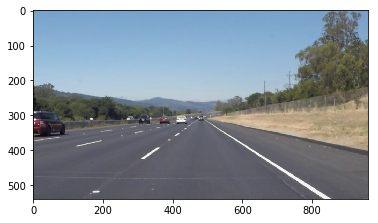

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    ##slope_list = []
    #intercept_list = []
    slope_one_sum = 0
    slope_two_sum = 0
    count_one_sum = 0
    count_two_sum = 0
    intercept_one_sum = 0
    intercept_two_sum = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            m_len = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            #print (m_len, x2, x1, y2, y1)
            if ((x2!= x1) and (m_len>30)):
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                slope = (y2-y1)/(x2-x1)
                intercept =  y1 - slope*x1
                #print (m_len, x2, x1, y2, y1, slope)
                #slope_list.append(slope)
                #intercept_list.append(intercept)
                if (slope > 0):
                    slope_one_sum += slope
                    count_one_sum += 1
                    intercept_one_sum += intercept
                    #m_one_x, m_one_y = get_x_y(x1,y1,x2,y2, m_one_x, m_one_y, max_one_y)
                elif (slope < 0):
                    slope_two_sum += slope
                    count_two_sum += 1
                    intercept_two_sum += intercept
                    #m_two_x, m_two_y = get_x_y(x1,y1,x2,y2, m_two_x, m_two_y, max_two_y)
    if not count_two_sum:
        for line in lines:
            for x1,y1,x2,y2 in line:
                if ((x2!= x1)):
                    slope = (y2-y1)/(x2-x1)
                    intercept =  y1 - slope*x1 
                    slope_two_sum += slope
                    count_two_sum += 1
                    intercept_two_sum += intercept
    if not count_one_sum:
        for line in lines:
            for x1,y1,x2,y2 in line:
                if ((x2!= x1)):
                    slope = (y2-y1)/(x2-x1)
                    intercept =  y1 - slope*x1 
                    slope_one_sum += slope
                    count_one_sum += 1
                    intercept_one_sum += intercept                
                    
    slope_one_mean = slope_one_sum/count_one_sum
    slope_two_mean = slope_two_sum/count_two_sum
    intercept_one_mean = intercept_one_sum/count_one_sum
    intercept_two_mean = intercept_two_sum/count_two_sum
    print (slope_one_mean, slope_two_mean, intercept_one_mean, intercept_two_mean)
    m_y1_one = 540
    m_x1_one = (m_y1_one - intercept_one_mean)/slope_one_mean
    m_y1_two = 540
    m_x1_two = (m_y1_two - intercept_two_mean)/slope_two_mean 
    m_y2_one = 330
    m_x2_one = (m_y2_one - intercept_one_mean)/slope_one_mean
    m_y2_two = 330
    m_x2_two = (m_y2_two - intercept_two_mean)/slope_two_mean 

    cv2.line(img, (int(m_x2_one), int(m_y2_one)), (int(m_x1_one), int(m_y1_one)), color, thickness)
    cv2.line(img, (int(m_x2_two), int(m_y2_two)), (int(m_x1_two), int(m_y1_two)), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #print (lines)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [6]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

In [7]:
# Read an image.
def image_pipeline(image):
    print('This image is:', type(image), 'with dimensions:', image.shape)
    #plt.subplot(2,3,1)
    #plt.imshow(image) 
    
    #gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 1
    blur_gray = gaussian_blur(gray,kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 90
    high_threshold = 180
    edges = canny(blur_gray, low_threshold, high_threshold)
    #plt.subplot(2,3,2)
    #plt.imshow(edges,cmap = 'gray')
    
    # Get the vertices. Make this generic
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(imshape[1]/2 - imshape[1]/30, imshape[0]/2 + 30), (imshape[1]/2 + imshape[1]/30, imshape[0]/2 + 30), (imshape[1],imshape[0])]], dtype=np.int32)
    m_interest_region = region_of_interest(edges, vertices)
    #plt.subplot(2,3,3)
    #plt.imshow(m_interest_region,cmap = 'gray')

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/360 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 6 #minimum number of pixels making up a line
    max_line_gap = 1    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines_img = hough_lines(m_interest_region, rho, theta, threshold, min_line_length, max_line_gap)
    #plt.subplot(2,3,4)
    #plt.imshow(lines_img)
        
    # Create a "color" binary image to combine with line image
    lines_edges = weighted_img(lines_img, image)
    #plt.subplot(2,3,5)
    #plt.imshow(lines_edges)
    return lines_edges

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.552201801492 -0.791666666667 47.6646047262 687.458333333


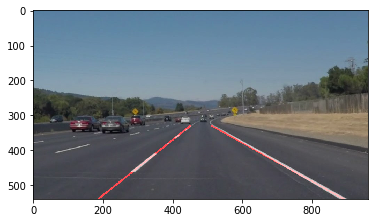

In [8]:
#Test on Image 1
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
fin_image = image_pipeline(image)
plt.imshow(fin_image)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.633367151484 -0.666666666667 1.73043860618 629.333333333


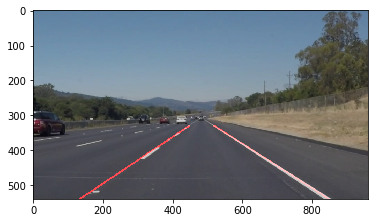

In [9]:
#Test on Image 2
image = mpimg.imread('test_images/solidWhiteRight.jpg')
fin_image = image_pipeline(image)
plt.imshow(fin_image)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.569944657301 -0.712680522245 46.3788846318 649.91981116


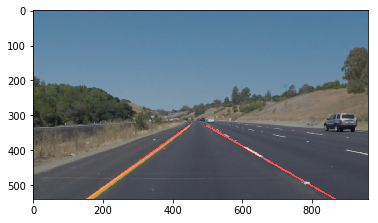

In [19]:
#Test on Image 3
image = mpimg.imread('test_images/solidYellowCurve.jpg')
fin_image = image_pipeline(image)
plt.imshow(fin_image)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.582194593787 -0.740867230834 33.4076500896 662.9287223


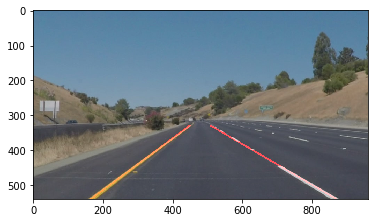

In [20]:
#Test on Image 4
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
fin_image = image_pipeline(image)
plt.imshow(fin_image)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.593546708301 -0.684451267117 29.3597883598 635.286396839


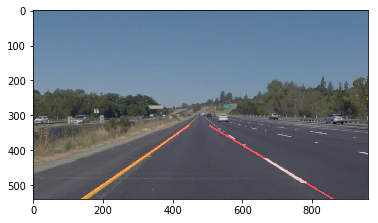

In [21]:
#Test on Image 5
image = mpimg.imread('test_images/solidYellowLeft.jpg')
fin_image = image_pipeline(image)
plt.imshow(fin_image)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.580354682593 -0.70122709815 30.7853201233 651.996706886


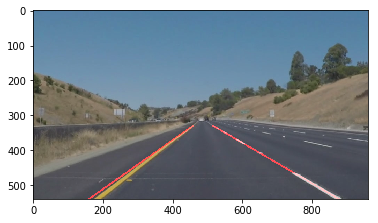

In [22]:
#Test on Image 6
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
fin_image = image_pipeline(image)
plt.imshow(fin_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = image_pipeline(image)
    print (result.shape)
    return result

Let's try the one with the solid white lane on the right first ...

In [25]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.628659784917 -0.745478386688 1.00764158395 659.203427383
(540, 960, 3)
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|                                                                            | 0/222 [00:00<?, ?it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.628659784917 -0.745478386688 1.00764158395 659.203427383
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.615207882595 -0.730800155096 10.9462383713 655.041844064
(540, 960, 3)


  1%|▌                                                                   | 2/222 [00:00<00:15, 13.85it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.609743994162 -0.720167080836 15.1580618649 651.226430649
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.62790843226 -0.713435200905 0.629745010879 648.618726655
(540, 960, 3)


  2%|█▏                                                                  | 4/222 [00:00<00:14, 14.97it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.620207088945 -0.774193548387 7.46645918101 673.096774194
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.614038931464 -0.727513227513 11.1905520756 652.079365079
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.626990601833 -0.707779886148 1.84428425985 644.921252372
(540, 960, 3)


  3%|██▏                                                                 | 7/222 [00:00<00:13, 16.27it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.607120855034 -0.748774509804 15.4366406344 660.871323529
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.646497023581 -0.711518255844 -8.99823975302 645.340622537
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.616231474087 -0.721247563353 10.9644469912 651.403508772
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.629126330993 -0.722537878788 7.77168256898 653.315340909
(540, 960, 3)


  5%|███▎                                                               | 11/222 [00:00<00:11, 18.99it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.633388976748 -0.738317564788 7.25299268666 660.664164267
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.631382524029 -0.729943013973 6.3275568844 654.078704105
(540, 960, 3)


  6%|███▉                                                               | 13/222 [00:00<00:10, 19.07it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.635060408931 -0.702515209147 3.02939914574 642.941982806
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.643654833739 -0.713181735918 -4.84619379337 646.204164671
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.636889359644 -0.747636554622 -1.61448551251 656.108193277
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.635495640024 0.138813284885 -1.4364862914 238.197991385
(540, 960, 3)


  8%|█████▏                                                             | 17/222 [00:00<00:09, 21.79it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.647109239614 -0.691851851852 -8.68543256498 636.311111111
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.648484381928 -0.730769230769 -9.56499680985 654.846153846
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.632114104326 -0.698948948949 5.49709720275 642.107357357
(540, 960, 3)


  9%|██████                                                             | 20/222 [00:00<00:08, 22.88it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.641277906464 -0.726023391813 0.31419789743 652.909356725
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.654261569725 -0.712323390895 -9.65228408642 648.462323391
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.637524434936 -0.717247947455 3.09744343994 649.373871921
(540, 960, 3)


 10%|██████▉                                                            | 23/222 [00:00<00:08, 24.63it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.634090313955 -0.694779116466 2.49253769206 642.859437751
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.643642734941 -0.704490584259 -6.12791745522 645.313133752
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.646521115561 -0.715620971621 -7.79539963889 648.997106301
(540, 960, 3)


 12%|███████▊                                                           | 26/222 [00:01<00:07, 25.02it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.647112694832 -0.697125603865 -7.92674079028 645.231751208
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.637148780534 -0.70820668693 -0.390687494674 647.522796353
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.630804902919 0.0571976528869 3.46900144286 278.528417839
(540, 960, 3)


 13%|████████▊                                                          | 29/222 [00:01<00:07, 25.48it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.664459100974 -0.731851851852 -18.8441747737 655.151851852
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.653174794433 -0.698709677419 -10.2568400797 641.08
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.646101628926 -0.737065637066 -6.73111211246 655.843243243
(540, 960, 3)


 14%|█████████▋                                                         | 32/222 [00:01<00:08, 22.34it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.651111220228 -0.7165374677 -9.55166510938 648.191989664
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.640876611895 -0.720575022462 -5.94213308445 649.717430368
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.652847603263 -0.692433943089 -8.71905931266 640.718912602
(540, 960, 3)


 16%|██████████▌                                                        | 35/222 [00:01<00:08, 22.66it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.6300979151 -0.732472244892 4.93350519923 653.730149877
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.626972573921 -0.738452273412 5.84819405253 657.932640771
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.633609204307 -0.704144222564 2.08801644388 645.545327018
(540, 960, 3)


 17%|███████████▍                                                       | 38/222 [00:01<00:07, 23.37it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.62537127119 -0.726473166707 7.55138678156 651.872063407
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.638002265179 -0.685557498057 -1.30087038365 640.084013209
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.633311171564 -0.72 2.01688592981 647.36
(540, 960, 3)


 18%|████████████▎                                                      | 41/222 [00:01<00:07, 25.01it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.659834050706 -0.76 -17.0842976275 667.36
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.648991128185 -0.738685344828 -9.3920801578 655.52424569
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.653047416563 -0.751351351351 -11.7984107814 659.094594595
(540, 960, 3)


 20%|█████████████▎                                                     | 44/222 [00:01<00:07, 23.93it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.644418604931 -0.727513227513 -4.55479079456 650.457671958
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.659296783628 -0.699159663866 -13.0771644525 640.01363212
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.638550440158 -0.754310344828 -3.7004564046 658.103448276
(540, 960, 3)


 21%|██████████████▏                                                    | 47/222 [00:01<00:06, 25.46it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.648650624678 -0.705641233766 -7.53336967531 642.127475649
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.650184921764 -0.738374084483 -10.1335378988 652.058892742
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.643135954582 -0.704348459574 -6.17798739925 642.077266632
(540, 960, 3)


 23%|███████████████                                                    | 50/222 [00:02<00:06, 25.59it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.637721941522 -0.738119745658 -1.13987124828 651.918031835
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.646053323204 -0.701030902576 -7.10131857386 641.420399035
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.633644140514 -0.704901960784 -0.966040085423 640.995098039
(540, 960, 3)


 24%|███████████████▉                                                   | 53/222 [00:02<00:06, 24.62it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.646162720135 -0.685185185185 -4.69709795916 632.037037037
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.631063699423 -0.675763125763 5.79431207116 627.659401709
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.62945607958 -0.7 3.55478716637 638.742857143
(540, 960, 3)


 25%|████████████████▉                                                  | 56/222 [00:02<00:06, 24.49it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.644545262131 -0.720542635659 -2.93456745712 646.269379845
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.59126529575 -0.67735042735 24.0816320219 631.489316239
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.651068541132 -0.69486453202 -6.89170083312 637.63614532
(540, 960, 3)


 27%|█████████████████▊                                                 | 59/222 [00:02<00:06, 24.55it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.665002834394 -0.696726572529 -14.0029005881 637.578626444
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.657668561831 -0.681654270904 -8.9816933994 632.401397341
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.65154751168 -0.684815901656 -3.31347857886 633.663401121
(540, 960, 3)


 28%|██████████████████▋                                                | 62/222 [00:02<00:06, 24.29it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.655041604021 -0.693143518093 -7.21400229907 636.673846976
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.658086009239 -0.681818181818 -8.70558860331 634.090909091
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.655662187607 -0.0104630757258 -8.93865126643 311.821478082
(540, 960, 3)


 29%|███████████████████▌                                               | 65/222 [00:02<00:06, 24.11it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.65794115523 -0.642857142857 -7.70126108831 615.071428571
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.665500699561 -0.709677419355 -15.0801788974 642.709677419
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.588079818957 -0.652496626181 23.4264108679 618.062078273
(540, 960, 3)


 31%|████████████████████▌                                              | 68/222 [00:02<00:06, 23.70it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.669362580168 -0.674858602445 -15.4164991645 629.635632184
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.659304026274 -0.687904509284 -9.03961961891 632.860106101
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.658656902099 -0.664954967374 -9.88477809051 623.543389854
(540, 960, 3)


 32%|█████████████████████▍                                             | 71/222 [00:02<00:06, 24.23it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.657858796477 -0.695071982281 -9.36522945063 632.179844961
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.648655309955 -0.662090441981 -3.31695743683 624.734685132
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.655184889641 -0.66619005026 -7.18172400956 628.242768123
(540, 960, 3)


 33%|██████████████████████▎                                            | 74/222 [00:03<00:05, 25.37it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.655231334058 -0.688678267128 -6.34371386901 630.650993541
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.684047784163 -0.69536930731 -21.451382007 628.138155377
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.671235405519 -0.667641325536 -15.2628208018 624.226120858
(540, 960, 3)


 35%|███████████████████████▏                                           | 77/222 [00:03<00:05, 24.80it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.66089315458 -0.66 -6.62672884869 620.78
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.667972587833 -0.583333333333 -14.2070996381 591.25
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.663738915453 -0.681623931624 -10.4832931264 628.188034188
(540, 960, 3)


 36%|████████████████████████▏                                          | 80/222 [00:03<00:05, 24.90it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.685622332313 -0.651286213786 -24.1019193355 617.630973193
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.643974871926 -0.680213903743 -4.23020821561 627.202673797
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.663460430009 -0.669197870298 -10.9592122819 624.609583661
(540, 960, 3)


 37%|█████████████████████████                                          | 83/222 [00:03<00:05, 24.72it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.68677346491 -0.657116839451 -25.6661129892 619.56213225
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.691538206753 -0.663394006251 -26.2840138827 621.793693694
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.676433060998 -0.656851276743 -18.6616730426 617.721609731
(540, 960, 3)


 39%|█████████████████████████▉                                         | 86/222 [00:03<00:05, 24.80it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.689195454348 -0.647786458333 -22.9997887975 618.059895833
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.678059948083 -0.665982905983 -19.3417813043 625.891196581
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.692819164126 -0.645893055078 -28.8666142337 617.697225089
(540, 960, 3)


 40%|██████████████████████████▊                                        | 89/222 [00:03<00:05, 24.79it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.695349985993 -0.666666666667 -28.4949453879 623.666666667
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.693241333496 -0.655913978495 -26.4856806029 620.043010753
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.702538588174 -0.662837837838 -32.7173226695 624.810810811
(540, 960, 3)


 41%|███████████████████████████▊                                       | 92/222 [00:03<00:05, 23.87it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.701118621401 -0.662337662338 -30.4073130909 624.399350649
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.698335017743 -0.675850500851 -33.4035315885 629.06039501
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.691208724272 -0.6555448098 -30.5472105911 621.831237911
(540, 960, 3)


 43%|████████████████████████████▋                                      | 95/222 [00:03<00:05, 24.02it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.688622875837 -0.660987654321 -29.553707568 623.591111111
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.692451214286 -0.677145076004 -30.052788005 629.081046356
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.70490749381 -0.684427547752 -39.2846448349 631.579205855
(540, 960, 3)


 44%|█████████████████████████████▌                                     | 98/222 [00:04<00:05, 24.48it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.682528016405 -0.662110339054 -27.4240956948 622.278584162
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.69383395303 -0.664992826399 -29.9334974209 622.588235294
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.705086716888 -0.653333333333 -39.2914195242 619.8
(540, 960, 3)


 45%|██████████████████████████████                                    | 101/222 [00:04<00:04, 24.87it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.698576046458 -0.66091954023 -36.9003073692 622.655172414
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.678962412151 -0.685267857143 -22.4565471763 634.877232143
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.678030211971 -0.673453996983 -22.1895928404 632.222473605
(540, 960, 3)


 47%|██████████████████████████████▉                                   | 104/222 [00:04<00:04, 25.34it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.668365756697 -0.647473123083 -18.1831116777 621.812859227
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.687343871287 -0.673076923077 -31.9704230958 630.653846154
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.686865838567 -0.675243054143 -29.5362153802 632.699067106
(540, 960, 3)


 48%|███████████████████████████████▊                                  | 107/222 [00:04<00:04, 25.62it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.693824128147 -0.695279563204 -34.4857379544 637.617734467
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.694127120625 -0.676231587729 -34.5421609516 633.187833126
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.683953165512 -0.680761836097 -29.1785728375 632.786241288
(540, 960, 3)


 50%|████████████████████████████████▋                                 | 110/222 [00:04<00:04, 25.20it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.683898376852 -0.697081951409 -28.3884389958 638.024942032
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.660839984889 -0.659176029963 -15.8943561973 625.677902622
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.675573195287 -0.686411149826 -24.8981059481 636.578397213
(540, 960, 3)


 51%|█████████████████████████████████▌                                | 113/222 [00:04<00:04, 25.59it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.651644631373 -0.650344827586 -9.78973268653 620.331724138
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.681597646468 -0.709677419355 -28.5659353039 644.967741935
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.661847530722 -0.685714285714 -17.4795346696 636.4
(540, 960, 3)


 52%|██████████████████████████████████▍                               | 116/222 [00:04<00:04, 26.10it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.645579219308 -0.682926829268 -5.63721104559 635.902439024
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.670942443252 -0.677843803056 -20.4087012028 631.194397284
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.665821726117 -0.691528119869 -18.6625625579 633.814680829
(540, 960, 3)


 54%|███████████████████████████████████▍                              | 119/222 [00:04<00:03, 26.26it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.66463849111 -0.709502862729 -17.2668055138 639.535784108
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.65764396393 -0.663478276864 -13.310094995 628.953484531
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.660607582674 -0.668579071414 -14.1479680368 629.444134401
(540, 960, 3)


 55%|████████████████████████████████████▎                             | 122/222 [00:04<00:03, 26.48it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.644189428718 -0.6774002849 -6.08593531267 632.418390313
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.646749390205 -0.660714285714 -5.22028395531 627.157142857
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.651104605819 -0.677083333333 -8.00520106724 632.708333333
(540, 960, 3)


 56%|█████████████████████████████████████▏                            | 125/222 [00:05<00:03, 26.53it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.639843956613 0.100477029878 -3.94655767253 258.801083393
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.647542647266 -0.684065934066 -8.70697858294 637.513736264
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.652527836019 -0.687960687961 -11.6074133343 639.551597052
(540, 960, 3)


 58%|██████████████████████████████████████                            | 128/222 [00:05<00:03, 26.66it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.63700938715 -0.688081395349 -1.82692668482 640.448546512
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.632442151313 -0.72192513369 0.803329354712 652.56684492
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.647638858983 -0.709690893901 -10.4202705436 649.266081871
(540, 960, 3)


 59%|██████████████████████████████████████▉                           | 131/222 [00:05<00:03, 26.53it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.625469417866 -0.728070175439 7.39824813085 656.140350877
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.619577415444 -0.719065656566 5.56420773194 652.251893939
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.618270068322 -0.714933138714 8.84339346879 651.893692909
(540, 960, 3)


 60%|███████████████████████████████████████▊                          | 134/222 [00:05<00:03, 25.89it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.64242769811 -0.701299227145 -9.72515709473 644.536828881
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.629271835901 -0.727412917271 -0.814671284926 649.840620464
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.624535033438 -0.692926633019 5.03853420661 640.466827591
(540, 960, 3)


 62%|████████████████████████████████████████▋                         | 137/222 [00:05<00:03, 25.90it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.615495069444 0.31759999045 8.86425680154 154.940175282
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.619095560622 -0.68 6.44048340722 639.12
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.616611285219 -0.730555555556 9.71099768761 656.377777778
(540, 960, 3)


 63%|█████████████████████████████████████████▌                        | 140/222 [00:05<00:03, 26.13it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.62973909894 -0.696726572529 3.60801878068 645.081514763
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.636935734077 -0.733302411874 -0.633032170036 658.487476809
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.630625477759 -0.726082862524 1.11695011781 657.881920904
(540, 960, 3)


 64%|██████████████████████████████████████████▌                       | 143/222 [00:05<00:02, 26.91it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.628458896615 -0.739696969697 4.11236182946 660.89969697
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.62842206848 -0.74104859335 5.16650186264 661.112531969
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.633068840778 -0.716521776909 -2.3213686676 655.286380797
(540, 960, 3)


 66%|███████████████████████████████████████████▍                      | 146/222 [00:05<00:02, 25.53it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.6518132613 -0.726175152894 -14.4943455245 655.551832954
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.622975731544 -0.745782237087 3.03094841563 661.644518766
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.626738531099 -0.712962962963 1.5783523343 652.824074074
(540, 960, 3)


 67%|████████████████████████████████████████████▎                     | 149/222 [00:05<00:02, 25.64it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.626229288156 0.122583302055 1.04350173401 247.501983296
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.608690641143 -0.740384615385 11.6943154167 662.480769231
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.613729866289 -0.720779220779 8.63520146842 655.831168831
(540, 960, 3)


 68%|█████████████████████████████████████████████▏                    | 152/222 [00:06<00:02, 25.45it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.626457124841 -0.728174603175 2.74217943183 657.974206349
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.625019838382 -0.740000567908 0.28306634049 661.437416589
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.62616321966 -0.761164021164 0.564541094729 669.682751323
(540, 960, 3)


 70%|██████████████████████████████████████████████                    | 155/222 [00:06<00:02, 26.48it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.625999405527 -0.741088435374 -0.334384693381 660.818231293
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.618130974234 -0.74256799494 6.86101651671 661.276091082
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.600484133186 -0.736411736412 14.9927833604 658.508898509
(540, 960, 3)


 71%|██████████████████████████████████████████████▉                   | 158/222 [00:06<00:02, 26.31it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.607444022287 -0.737291947818 8.43697309972 658.526090868
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.604450145667 -0.745997339586 14.6272370312 660.077363585
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.584932334969 -0.733333333333 22.4155665561 655.6
(540, 960, 3)


 73%|███████████████████████████████████████████████▊                  | 161/222 [00:06<00:02, 25.61it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.601542367154 0.275144483781 12.8717189726 173.761083156
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.577506212447 -0.714285714286 29.1678806277 653.142857143
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.589539057236 -0.774193548387 21.42317615 682.387096774
(540, 960, 3)


 74%|████████████████████████████████████████████████▊                 | 164/222 [00:06<00:02, 25.25it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.587293210553 -0.777777777778 22.0164560243 684.333333333
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.604200879007 -0.75 13.2074586139 667.75
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.590328605483 -0.788461538462 23.7944083649 689.211538462
(540, 960, 3)


 75%|█████████████████████████████████████████████████▋                | 167/222 [00:06<00:02, 25.44it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.579796789398 -0.781172456576 28.9778150148 684.287479322
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.604908181965 -0.776341463415 13.9208170191 680.707073171
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.581161452233 -0.802036199095 27.4650158397 690.446832579
(540, 960, 3)


 77%|██████████████████████████████████████████████████▌               | 170/222 [00:06<00:02, 25.15it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.595414851256 -0.769968522526 19.9947794794 681.908272674
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.59218370625 -0.762359821121 21.8172612104 677.163288614
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.601907881966 -0.775 12.1729048776 681.925
(540, 960, 3)


 78%|███████████████████████████████████████████████████▍              | 173/222 [00:06<00:01, 25.37it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.596925611831 0.139107975728 17.5847397496 238.901172373
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.582142982777 -0.764615384615 25.9662144911 676.835384615
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.586609529109 0.139794061224 24.7553022665 243.192041645
(540, 960, 3)


 79%|████████████████████████████████████████████████████▎             | 176/222 [00:07<00:01, 25.52it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.586806813399 -0.818181818182 23.5394104882 701.545454545
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.59633278725 -0.795833333333 18.6021808755 689.745833333
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.570224000827 -0.805925925926 32.6386181979 693.688888889
(540, 960, 3)


 81%|█████████████████████████████████████████████████████▏            | 179/222 [00:07<00:01, 25.86it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.587236258252 -0.808333333333 22.3682751088 693.508333333
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.580611169352 -0.799788601073 26.019593212 689.730732515
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.585631199228 -0.817962231006 22.9976397338 697.895476504
(540, 960, 3)


 82%|██████████████████████████████████████████████████████            | 182/222 [00:07<00:01, 25.67it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.573148660652 -0.803022030651 30.7065698594 693.193687739
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.565787209556 -0.796296296296 36.8869432099 687.388888889
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.595899573919 -0.797658862876 15.7247083886 689.628762542
(540, 960, 3)


 83%|███████████████████████████████████████████████████████           | 185/222 [00:07<00:01, 25.73it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.59808954826 0.160465992476 11.5037252047 231.075067648
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.582273226095 -0.791666666667 26.1413405425 688.916666667
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.580180738275 -0.772167487685 23.5369514098 677.325123153
(540, 960, 3)


 85%|███████████████████████████████████████████████████████▉          | 188/222 [00:07<00:01, 25.71it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.575726391845 -0.808888888889 27.2014701005 689.882222222
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.57569896765 -0.809782608696 23.2488114628 687.652173913
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.56438603645 -0.769047619048 32.0554937301 675.55952381
(540, 960, 3)


 86%|████████████████████████████████████████████████████████▊         | 191/222 [00:07<00:01, 26.49it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.562110955703 -0.787356321839 32.3288504227 683.663793103
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.569732242175 -0.782093892813 31.1891700636 685.213128376
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.577441461311 -0.799212056304 26.3533993227 690.908238984
(540, 960, 3)


 87%|█████████████████████████████████████████████████████████▋        | 194/222 [00:07<00:01, 25.23it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.570414363729 -0.803659599341 31.6184028388 688.880232744
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.584106634689 -0.784923477695 25.4580315512 685.971996092
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.566245956282 -0.79797979798 35.1628236212 688.424242424
(540, 960, 3)


 89%|██████████████████████████████████████████████████████████▌       | 197/222 [00:07<00:00, 25.42it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.569669794307 0.179120873941 33.1091343538 227.362078783
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.573751358937 -0.795833333333 30.5909313077 687.2875
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.56805198868 -0.741935483871 36.3110183609 665.161290323
(540, 960, 3)


 90%|███████████████████████████████████████████████████████████▍      | 200/222 [00:07<00:00, 25.56it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.57022279507 -0.793103448276 34.3976336607 683.413793103
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.568625299444 -0.756097560976 35.6916246753 668.975609756
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.57732464273 -0.81683626272 28.2395532075 695.257169288
(540, 960, 3)


 91%|████████████████████████████████████████████████████████████▎     | 203/222 [00:08<00:00, 26.42it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.567931601593 -0.791769041769 32.746407839 686.154791155
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.57363297468 -0.786809811688 26.4408762971 684.132197207
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.565813917761 -0.785106382979 36.2713907417 682.652056738
(540, 960, 3)


 93%|█████████████████████████████████████████████████████████████▏    | 206/222 [00:08<00:00, 25.13it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.566701196619 -0.822090032616 30.444416854 694.873399716
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.562960684526 -0.802174975562 34.5595398251 688.676075269
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.562912861398 -0.78 35.2173315208 677.06
(540, 960, 3)


 94%|██████████████████████████████████████████████████████████████▏   | 209/222 [00:08<00:00, 26.39it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.56234231812 -0.0332963273758 33.0470273705 328.084919924
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.556675364395 -0.791666666667 40.0294060152 681.166666667
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.567570671821 -0.821428571429 30.901101668 699.714285714
(540, 960, 3)


 95%|███████████████████████████████████████████████████████████████   | 212/222 [00:08<00:00, 26.24it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.562608667202 -0.102061946774 38.9737225456 356.725936621
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.562096122228 -0.846153846154 37.8896524896 709.615384615
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.567648931535 -0.775 34.8086445367 681.0
(540, 960, 3)


 97%|███████████████████████████████████████████████████████████████▉  | 215/222 [00:08<00:00, 26.15it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.565674659661 -0.823529411765 33.9471188373 693.294117647
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.558877758685 -0.783734245755 41.7165968395 684.94852538
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.556128180081 -0.77006433008 44.0119084088 678.533961846
(540, 960, 3)


 98%|████████████████████████████████████████████████████████████████▊ | 218/222 [00:08<00:00, 26.08it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.558477069394 -0.788707224797 41.6178764373 683.029610841
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.551665198298 -0.793301466254 42.9292038966 685.797224985
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.563309995131 -0.774938271605 38.2687744105 679.014691358
(540, 960, 3)


100%|█████████████████████████████████████████████████████████████████▋| 221/222 [00:08<00:00, 26.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 9.32 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [27]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.698842592593 -0.656219223173 -36.3199074074 623.282846823
(540, 960, 3)
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|                                                                            | 0/682 [00:00<?, ?it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.698842592593 -0.656219223173 -36.3199074074 623.282846823
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.680479581566 -0.649188992654 -24.2445929986 619.47702968
(540, 960, 3)


  0%|▏                                                                   | 2/682 [00:00<00:35, 18.91it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.65360208419 -0.639216026938 -3.51534896476 617.291869163
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.685796269727 -0.727156592061 -29.9558823529 659.864242795
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.692708333333 -0.700902873429 -37.25 643.28715258
(540, 960, 3)


  1%|▍                                                                   | 5/682 [00:00<00:31, 21.25it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.76 -0.655840813499 -71.36 626.433767735
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.685267857143 -0.741485716265 -29.3616071429 668.316797909
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.690990990991 -0.659858446195 -34.5072072072 625.011313461
(540, 960, 3)


  1%|▊                                                                   | 8/682 [00:00<00:28, 23.25it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.657142857143 -0.686346501006 -18.0571428571 638.199562037
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.661059018202 -0.685717384701 -17.3306674021 638.729023739
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.663614163614 -0.650508940637 -19.5396825397 619.666685426
(540, 960, 3)


  2%|█                                                                  | 11/682 [00:00<00:29, 23.12it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.670114942529 -0.696663790126 -23.5114942529 640.846683473
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.641239986068 -0.688784262819 -6.68164402647 637.363271239
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.662679038485 -0.681251408065 -19.6818159173 635.891298308
(540, 960, 3)


  2%|█▍                                                                 | 14/682 [00:00<00:28, 23.05it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.636709615279 -0.708408569275 -6.48198501783 649.917325243
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.650484332753 -0.700797385902 -12.8390093337 641.554258226
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.644703425701 -0.667567573087 -7.5641401885 628.785360724
(540, 960, 3)


  2%|█▋                                                                 | 17/682 [00:00<00:29, 22.92it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.62962962963 -0.730675660267 -0.740740740741 654.808716754
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.633333333333 -0.704257273044 -4.0 646.906404081
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.645833333333 -0.716844356955 -8.875 647.997909309
(540, 960, 3)


  3%|█▉                                                                 | 20/682 [00:00<00:27, 24.32it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.675 -0.717593661645 -26.075 649.242332356
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.643725490196 -0.754145111161 -9.37470588235 665.155255378
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.655084745763 -0.715634588975 -16.4889830508 646.61468129
(540, 960, 3)


  3%|██▎                                                                | 23/682 [00:00<00:26, 25.25it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.639303482587 -0.772276240563 -6.26865671642 673.695270564
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.623155341801 -0.754150447305 5.55060221153 664.016018402
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.648832951945 -0.718749645447 -13.1870556827 653.436211217
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.620752296414 -0.809364560639 5.49193782017 690.31879085
(540, 960, 3)


  4%|██▋                                                                | 27/682 [00:01<00:24, 26.23it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.618671870135 -0.664643933218 6.57326399887 627.759439273
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.612556629417 -0.734437450496 5.31140138931 651.001353293
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.593135259802 -0.764751765539 19.3847510514 667.642899143
(540, 960, 3)


  4%|██▉                                                                | 30/682 [00:01<00:23, 27.23it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.611263736264 -0.730820884614 5.2760989011 656.795525051
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.606601731602 -0.743561653607 8.20346320346 658.919345559
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.639784946237 -0.711644685169 -10.8870967742 647.63480095
(540, 960, 3)


  5%|███▏                                                               | 33/682 [00:01<00:23, 27.62it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.609756097561 -0.743597529921 5.73170731707 657.406878024
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.647712418301 -0.756938108274 -15.1124183007 664.385669246
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.618594210667 -0.755729580827 2.62716429912 665.122161922
(540, 960, 3)


  5%|███▌                                                               | 36/682 [00:01<00:23, 27.45it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.618503118503 -0.764757799383 2.53534303534 663.389401727
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.631094089018 -0.750765757979 -5.98366118843 663.493111902
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.606416582889 -0.764622599549 9.30110777436 661.046139791
(540, 960, 3)


  6%|███▊                                                               | 39/682 [00:01<00:25, 25.44it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.600936012834 -0.775274507925 13.8360486478 668.595100904
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.603128908129 -0.768117756125 10.755016835 665.193775445
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.615275093014 -0.735289963764 3.85921099125 653.271386805
(540, 960, 3)


  6%|████▏                                                              | 42/682 [00:01<00:25, 25.03it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.58064516129 -0.765770850396 22.4193548387 666.313839215
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.606060606061 -0.770905769794 7.57575757576 666.383096869
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.635023041475 -0.811315219092 -6.13271889401 684.160502415
(540, 960, 3)


  7%|████▍                                                              | 45/682 [00:01<00:24, 25.84it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.722257215823 -0.740367309939 -51.5878496503 657.253906602
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.715212023618 -0.722093181041 -46.4959312936 643.776129271
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.613559322034 -0.719292846589 8.45762711864 643.229004656
(540, 960, 3)


  7%|████▋                                                              | 48/682 [00:01<00:24, 25.86it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.626392211864 -0.750316511805 0.466408162143 657.255492474
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.629406886296 -0.720628466877 -3.12706331503 644.169942696
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.602544233501 -0.742719724951 16.8029187653 656.031334594
(540, 960, 3)


  7%|█████                                                              | 51/682 [00:01<00:24, 25.54it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.599411298624 -0.72324779967 17.5695522965 647.220625506
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.61562429912 -0.746532194993 6.76070687251 657.841430171
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.600854454685 -0.692612021437 14.7772177419 632.186785606
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.613613717552 -0.716197761893 10.6701633722 642.030159884
(540, 960, 3)


  8%|█████▍                                                             | 55/682 [00:02<00:23, 26.77it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.620689655172 -0.75562388811 7.65517241379 658.448056779
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.451839389359 -0.724268185499 517.513869151 644.765378282
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.614285714286 -0.71003738544 10.3428571429 638.05902239
(540, 960, 3)


  9%|█████▋                                                             | 58/682 [00:02<00:26, 23.54it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.178916848624 -0.694060241939 385.482426282 632.794896863
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.632518796992 -0.729984100795 -1.29887218045 647.929449194
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.60403085615 -0.734672859123 19.0167861799 654.031225564
(540, 960, 3)


  9%|█████▉                                                             | 61/682 [00:02<00:28, 22.17it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.624676285609 -0.694347784742 3.41231964484 631.867064141
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.607536437967 -0.710932536235 15.4742268041 640.929426017
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.589400425788 -0.696709947632 28.4425568103 635.652203658
(540, 960, 3)


  9%|██████▎                                                            | 64/682 [00:02<00:27, 22.78it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.589762441032 -0.721085358419 30.0242345704 646.023147739
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.592585488753 -0.718684182542 26.9774671005 643.871595759
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.601368851124 -0.738155542112 19.0748618183 653.1142334
(540, 960, 3)


 10%|██████▌                                                            | 67/682 [00:02<00:26, 23.48it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.62962962963 -0.640897180852 0.037037037037 608.053094315
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.204606030851 -0.709631391371 405.34425273 642.15922147
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.661428571429 -0.701061778737 -16.8585714286 638.60623575
(540, 960, 3)


 10%|██████▉                                                            | 70/682 [00:02<00:25, 23.83it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.624031007752 -0.750851543957 6.00387596899 662.670305388
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.567567567568 -0.741893865181 39.5135135135 659.853880624
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.629651860744 -0.69586419332 3.11764705882 637.780414623
(540, 960, 3)


 11%|███████▏                                                           | 73/682 [00:02<00:24, 24.43it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.610697018533 -0.692120711462 16.2723609992 635.185618836
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.606132509289 -0.694843061058 21.8107640805 634.534699187
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.614230616835 -0.700035083533 16.0875496891 638.657768553
(540, 960, 3)


 11%|███████▍                                                           | 76/682 [00:03<00:24, 24.71it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.607443743857 -0.659977747599 21.0408322354 622.745600962
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.63225363954 -0.70546624297 1.08923975483 640.78686874
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.633778142675 -0.714081081003 -0.157478197409 644.126099283
(540, 960, 3)


 12%|███████▊                                                           | 79/682 [00:03<00:24, 24.58it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.630846074749 -0.678051224411 7.8395302243 629.033714104
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.630208333333 -0.738553112327 3.75520833333 656.453776419
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.658035714286 -0.710752470204 -13.0223214286 643.629378007
(540, 960, 3)


 12%|████████                                                           | 82/682 [00:03<00:23, 25.73it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.680555555556 -0.698182652128 -23.9027777778 637.036300896
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.632267280286 -0.671944790352 1.28820116054 623.32159691
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.666428267348 -0.707386266963 -17.6545423585 639.696416521
(540, 960, 3)


 12%|████████▎                                                          | 85/682 [00:03<00:24, 24.78it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.611940298507 -0.702549992462 12.7611940299 641.618554847
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.61978381096 -0.631151593771 10.1166415284 605.473699005
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.619777099754 -0.689687245394 13.8222518858 631.580520066
(540, 960, 3)


 13%|████████▋                                                          | 88/682 [00:03<00:22, 26.12it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.632284148623 -0.695401175796 4.6544039027 637.078156454
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.648110269078 -0.691992113972 -7.03932991836 633.987935694
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.618096729208 -0.705266700137 12.9848138737 642.886509455
(540, 960, 3)


 13%|████████▉                                                          | 91/682 [00:03<00:22, 26.05it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.628246753247 -0.682397778529 7.97077922078 632.183922559
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.602599352599 -0.7001204091 28.2295737296 644.258348939
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.653846153846 -0.67048538542 -4.23076923077 627.138921613
(540, 960, 3)


 14%|█████████▏                                                         | 94/682 [00:03<00:22, 26.00it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.666666666667 -0.674020805609 -14.0555555556 630.347444958
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.607142857143 -0.731079347384 18.9285714286 657.326863354
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.654977375566 -0.654493689525 -8.14819004525 617.613259237
(540, 960, 3)


 14%|█████████▌                                                         | 97/682 [00:03<00:22, 25.99it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.632142857143 -0.65889371232 5.54285714286 625.275693692
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.645161290323 -0.717149626277 -6.51612903226 652.307524325
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.67816091954 -0.644263326367 -21.6666666667 614.544738014
(540, 960, 3)


 15%|█████████▋                                                        | 100/682 [00:03<00:22, 25.54it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.644279423928 -0.650221978611 -3.04574149759 615.903839033
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.682279411765 -0.63598511161 -30.3708333333 611.278310314
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.625402711064 -0.659092619234 10.3863984802 622.845394978
(540, 960, 3)


 15%|█████████▉                                                        | 103/682 [00:04<00:22, 25.64it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.632074920771 -0.696481591944 6.75235979062 642.726257265
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.680236983221 -0.648610699373 -21.4513319495 620.208293649
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.619633838384 -0.656506396624 13.1919191919 620.656518139
(540, 960, 3)


 16%|██████████▎                                                       | 106/682 [00:04<00:22, 25.72it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.626436781609 -0.611271929825 7.11494252874 600.465038986
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.628302253302 -0.71141446497 7.03525641026 648.402788
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.58064516129 -0.649517231135 33.6129032258 619.682034714
(540, 960, 3)


 16%|██████████▌                                                       | 109/682 [00:04<00:22, 25.77it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.626726726727 -0.688459615581 8.17477477477 639.109254413
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.636530612245 -0.702892353051 2.19020408163 646.35572767
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.649993524994 -0.642670753577 -4.85903910904 618.30197727
(540, 960, 3)


 16%|██████████▊                                                       | 112/682 [00:04<00:22, 25.81it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.642375995101 -0.698521949288 -2.46631965707 641.498193715
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.648585208414 -0.671804602733 -6.01320349893 631.053463862
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.634014095103 -0.71530250687 2.12843777036 648.413661237
(540, 960, 3)


 17%|███████████▏                                                      | 115/682 [00:04<00:22, 24.83it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.618129081296 -0.694599229948 13.4037152232 641.875771683
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.610256655596 -0.723961918269 17.6063357285 653.707468574
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.635588972431 -0.713241018351 0.0711779448621 647.020921291
(540, 960, 3)


 17%|███████████▍                                                      | 118/682 [00:04<00:24, 23.19it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.6 -0.670014263384 16.6 629.344056381
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.571428571429 -0.699236860989 37.2857142857 642.146664589
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.630630630631 -0.657752552714 3.78828828829 620.38758129
(540, 960, 3)


 18%|███████████▋                                                      | 121/682 [00:04<00:24, 22.86it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.620689655172 -0.657771574993 13.1379310345 624.500149345
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.616439909297 -0.655313857161 14.0778911565 622.558618629
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.639880952381 -0.693811479329 -1.70833333333 644.118945753
(540, 960, 3)


 18%|████████████                                                      | 124/682 [00:04<00:23, 23.33it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.626160990712 -0.671849723416 6.49613003096 633.058393441
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.628924317062 -0.660213557433 4.35684549933 626.122889075
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.647871148459 -0.671214024866 -7.57268907563 629.218896269
(540, 960, 3)


 19%|████████████▎                                                     | 127/682 [00:05<00:23, 24.04it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.627758674202 -0.712566418214 6.64796005628 644.105967263
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.628306445328 -0.704957728064 5.78721066168 646.249712688
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.604027816157 -0.666450439396 21.8684914355 626.530613502
(540, 960, 3)


 19%|████████████▌                                                     | 130/682 [00:05<00:23, 23.84it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.617647058824 -0.648575575792 7.20588235294 620.002341426
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.641737891738 -0.712607251269 -2.58903133903 648.422059908
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.657327586207 -0.667259454364 -12.1702586207 626.881673703
(540, 960, 3)


 20%|████████████▊                                                     | 133/682 [00:05<00:21, 25.20it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.589030206677 -0.648760324922 25.9348171701 621.503951173
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.65 -0.695441774392 -8.3 641.899465215
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.646453089245 -0.658834497761 -5.63844393593 625.962785936
(540, 960, 3)


 20%|█████████████▏                                                    | 136/682 [00:05<00:21, 25.40it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.607142857143 -0.698304703568 17.3952380952 645.882934856
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.574379324379 -0.697970559061 36.225986976 644.607696237
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.624266308905 -0.667941023085 8.68153613953 628.603723972
(540, 960, 3)


 20%|█████████████▍                                                    | 139/682 [00:05<00:21, 25.57it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.576714448186 -0.696201765192 37.768163624 645.237437752
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.616533758639 -0.705510602597 14.0246943115 646.138746571
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.616409240797 -0.648734386001 15.7177695954 620.582095267
(540, 960, 3)


 21%|█████████████▋                                                    | 142/682 [00:05<00:21, 25.28it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.622751322751 -0.676676143216 6.87222222222 632.903500456
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.586206896552 -0.654590223336 28.4827586207 622.924817185
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.666256157635 -0.631075616496 -14.4248768473 615.344142145
(540, 960, 3)


 21%|██████████████                                                    | 145/682 [00:05<00:22, 23.56it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.689655172414 -0.667803039057 -29.0344827586 630.393574667
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.680814940577 -0.669102982116 -24.421901528 628.534067771
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.666666666667 -0.650733723581 -16.0 622.516269267
(540, 960, 3)


 22%|██████████████▎                                                   | 148/682 [00:05<00:23, 22.37it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.618303571429 -0.701761998282 11.3973214286 644.793557376
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.620987654321 -0.668695786852 11.162962963 632.394888222
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.625173250173 -0.705494880384 8.16285516286 647.025358812
(540, 960, 3)


 22%|██████████████▌                                                   | 151/682 [00:06<00:22, 23.13it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.589067876568 -0.710969833811 32.4481712732 650.446484644
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.596309673942 -0.699708329743 27.7829900113 646.807145643
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.618815501628 -0.69863871446 6.78221662597 647.590530258
(540, 960, 3)


 23%|██████████████▉                                                   | 154/682 [00:06<00:24, 21.29it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.603918618812 -0.693850561935 22.2050934881 647.765254672
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.639784946237 -0.706342231506 -6.74731182796 650.470591337
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.586206896552 -0.638152096945 28.6206896552 618.639218023
(540, 960, 3)


 23%|███████████████▏                                                  | 157/682 [00:06<00:25, 20.93it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.570609318996 -0.701294080275 38.4089605735 650.566900609
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.638888888889 -0.695205888335 1.83333333333 649.984187363
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.604276069017 -0.688487451365 20.7734433608 646.340471257
(540, 960, 3)


 23%|███████████████▍                                                  | 160/682 [00:06<00:24, 21.46it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.612691230338 -0.711085527323 15.8945988652 659.618386145
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.62470583976 -0.699830419274 7.12447051157 651.908496728
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.607594936709 -0.656116966183 20.4556962025 631.016063345
(540, 960, 3)


 24%|███████████████▊                                                  | 163/682 [00:06<00:24, 21.55it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.574416106009 -0.718990537822 40.9220451425 659.919069992
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.566617448013 -0.715329140561 43.9924603175 659.356618292
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.590538074641 -0.717045336653 26.6740148294 659.266631553
(540, 960, 3)


 24%|████████████████                                                  | 166/682 [00:06<00:23, 21.93it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.580763288672 -0.660214502523 32.3705512753 633.490138305
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.58884999856 -0.727369136796 28.0263734048 664.192081288
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.528439153439 -0.685322934783 58.8141534392 641.723843183
(540, 960, 3)


 25%|████████████████▎                                                 | 169/682 [00:06<00:22, 22.85it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.470588235294 -0.690787585115 88.4705882353 645.559484125
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.532591414944 -0.654390261066 56.2758346582 626.536401508
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.595238095238 -0.674233777479 23.3333333333 639.665374575
(540, 960, 3)


 25%|████████████████▋                                                 | 172/682 [00:07<00:21, 23.80it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.557142857143 -0.730936943726 43.1714285714 667.296410326
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.583926698681 -0.733951058275 27.6716895733 667.196898915
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.53892801252 -0.762207872688 51.1050469484 676.153086637
(540, 960, 3)


 26%|████████████████▉                                                 | 175/682 [00:07<00:21, 23.75it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.592504743833 -0.793673295446 23.545540797 690.611715938
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.569134266344 -0.767773863735 35.8430129897 678.292592896
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.555221750874 -0.779343165378 42.8819704098 685.016287291
(540, 960, 3)


 26%|█████████████████▏                                                | 178/682 [00:07<00:20, 24.69it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.570546088788 -0.740317477832 34.4109982424 668.950403309
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.567658304232 -0.764251526646 36.2871525265 679.300515503
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.555962152111 -0.724194634013 44.6606302176 660.258819301
(540, 960, 3)


 27%|█████████████████▌                                                | 181/682 [00:07<00:20, 25.04it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.551167964405 -0.720147822592 46.5088987764 657.865098971
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.528571428571 -0.720887167741 58.8857142857 657.400435262
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.557747010333 -0.76365164192 42.4980117265 681.179194025
(540, 960, 3)


 27%|█████████████████▊                                                | 184/682 [00:07<00:19, 25.99it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.537234042553 -0.772108447092 56.9414893617 682.027795456
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.549870801034 -0.727832171296 47.7896640827 659.440355957
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.53468013468 -0.707283232745 59.2713804714 649.68359171
(540, 960, 3)


 27%|██████████████████                                                | 187/682 [00:07<00:19, 24.96it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.53681041181 -0.697570004133 57.8816045066 647.068728356
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.5636693428 -0.772327935559 40.9430383013 680.313078515
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.546204883981 -0.787935951148 54.2249093894 688.079552429
(540, 960, 3)


 28%|██████████████████▍                                               | 190/682 [00:07<00:19, 25.29it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.546470239288 -0.712771442116 51.5106647155 652.250713708
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.54311070497 -0.721992889185 56.6187071648 655.417802861
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.532971014493 -0.796206058227 60.3986413043 689.384542971
(540, 960, 3)


 28%|██████████████████▋                                               | 193/682 [00:07<00:21, 23.10it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.607142857143 -0.782646020014 17.7857142857 681.646349344
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.551724137931 -0.776047932193 50.6206896552 678.379843674
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.538461538462 -0.715502443399 59.7692307692 650.978062778
(540, 960, 3)


 29%|██████████████████▉                                               | 196/682 [00:08<00:20, 23.20it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.560686653772 -0.772910940366 46.3597678917 677.857210376
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.577890662796 -0.796995234408 36.6526366715 686.767111194
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.611111111111 -0.773361381901 14.2666666667 679.04901306
(540, 960, 3)


 29%|███████████████████▎                                              | 199/682 [00:08<00:21, 22.97it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.571428571429 -0.743076394743 42.0 661.615117838
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.575932017544 -0.75941776373 39.180372807 672.5225601
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.548214285714 -0.763298649686 56.6410714286 669.817690682
(540, 960, 3)


 30%|███████████████████▌                                              | 202/682 [00:08<00:20, 23.15it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.56242178583 -0.749445908703 44.6655694394 665.706511467
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.561865039958 -0.73334317838 45.717863842 659.120288394
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.560931174089 -0.745519195376 56.1730769231 666.155401858
(540, 960, 3)


 30%|███████████████████▊                                              | 205/682 [00:08<00:20, 23.54it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.591491841492 -0.765515537392 29.2354312354 674.35968981
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.556448412698 -0.761555529242 50.9544642857 675.011121371
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.59375 -0.715623819279 30.53125 654.286286773
(540, 960, 3)


 30%|████████████████████▏                                             | 208/682 [00:08<00:20, 23.24it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.575 -0.706093229896 41.125 644.404654634
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.621621621622 -0.720704806945 11.7297297297 652.397354624
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.562200956938 -0.750021782602 47.2775119617 667.31479197
(540, 960, 3)


 31%|████████████████████▍                                             | 211/682 [00:08<00:20, 22.95it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.562143776429 -0.705760738697 47.0801617944 646.527767085
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.597209942038 -0.698388680999 26.5610570783 643.748762631
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.587618054634 -0.728998194031 32.9345066444 661.805332094
(540, 960, 3)


 31%|████████████████████▋                                             | 214/682 [00:08<00:20, 23.13it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.58294358457 -0.760534185633 37.0346316135 672.601452409
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.590512126735 -0.722339911884 29.8925768104 654.956309976
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.582075124949 -0.697003608328 38.1915038252 641.349060053
(540, 960, 3)


 32%|█████████████████████                                             | 217/682 [00:08<00:20, 22.46it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.587359022556 -0.719529633642 31.2984492481 654.056818028
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.577011494253 -0.726341609479 38.691954023 657.015816743
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.575757575758 -0.627631215088 37.2727272727 611.336528012
(540, 960, 3)


 32%|█████████████████████▎                                            | 220/682 [00:09<00:20, 22.61it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.568100358423 -0.722793534626 44.5770609319 657.033411054
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.584343434343 -0.719807339757 34.2747474747 653.755055917
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.607843137255 -0.742376766167 22.3529411765 662.87983698
(540, 960, 3)


 33%|█████████████████████▌                                            | 223/682 [00:09<00:20, 22.53it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.5890625 -0.726055454491 31.35625 657.397855692
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.56320035461 -0.75327191446 43.5912765957 669.210832018
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.596439628483 -0.743653521474 28.1099071207 662.084695916
(540, 960, 3)


 33%|█████████████████████▊                                            | 226/682 [00:09<00:20, 22.65it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.584245985724 -0.695404369694 35.2524429138 638.289924001
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.579601508424 -0.722406234082 40.526727994 657.787987147
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.594310105064 -0.719022811351 26.3712944098 654.720707203
(540, 960, 3)


 34%|██████████████████████▏                                           | 229/682 [00:09<00:20, 22.10it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.584127685542 -0.732587030724 33.9231109147 656.947256926
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.615384615385 -0.730347263856 15.0 654.795030678
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.678571428571 -0.70428114769 -22.3571428571 647.644463412
(540, 960, 3)


 34%|██████████████████████▍                                           | 232/682 [00:09<00:19, 22.70it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.612903225806 -0.724027988474 18.0322580645 655.635430864
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.628571428571 -0.765766311901 8.94285714286 674.852345384
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.605263157895 -0.704436495984 23.7631578947 647.45814508
(540, 960, 3)


 34%|██████████████████████▋                                           | 235/682 [00:09<00:19, 22.69it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.636666666667 -0.704250043255 2.42666666667 644.995786692
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.617551462622 -0.751673169314 14.1538461538 665.19432324
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.635029239766 -0.711280069465 0.372543859649 650.225106723
(540, 960, 3)


 35%|███████████████████████                                           | 238/682 [00:09<00:20, 22.10it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.56856452934 -0.707537507237 39.4869100248 647.188110131
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.600439695109 -0.699485870774 22.8898427961 644.244176951
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.605801267876 -0.649521797094 17.9321833997 619.697444491
(540, 960, 3)


 35%|███████████████████████▎                                          | 241/682 [00:09<00:19, 22.72it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.624343891403 -0.70668397085 3.65761689291 646.060570779
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.580103359173 -0.745449112895 34.6718346253 663.358376515
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.569047619048 -0.724363553114 40.8095238095 652.632403846
(540, 960, 3)


 36%|███████████████████████▌                                          | 244/682 [00:10<00:18, 23.49it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.564532019704 -0.707293763396 45.0201970443 647.246342896
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.575757575758 -0.662149585391 41.7272727273 625.562033395
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.597502153316 -0.677144853642 26.7061154177 634.344803871
(540, 960, 3)


 36%|███████████████████████▉                                          | 247/682 [00:10<00:18, 23.11it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.575052854123 -0.640576925164 39.7156448203 616.930383022
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.571743171743 -0.661502248899 43.6007436007 625.713175758
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.615240968182 -0.693073002582 15.812863607 639.786100545
(540, 960, 3)


 37%|████████████████████████▏                                         | 250/682 [00:10<00:19, 22.57it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.605330490405 -0.637139410728 20.8690831557 616.958345144
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.574010093168 -0.695736660525 41.2961956522 642.900932204
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.581238258597 -0.678965171097 39.1937858368 634.992109553
(540, 960, 3)


 37%|████████████████████████▍                                         | 253/682 [00:10<00:18, 22.96it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.574799756463 -0.724328884335 44.2859861125 653.572048722
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.586588050314 -0.642386310691 35.5382232704 618.70738124
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.582628446115 -0.724049104297 38.1291510025 654.557110409
(540, 960, 3)


 38%|████████████████████████▊                                         | 256/682 [00:10<00:18, 22.87it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.13491576319 -0.7145607903 384.47788505 651.066081312
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.517857142857 -0.675797233728 67.875 632.019073725
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.586206896552 -0.675097501369 30.4482758621 631.068025195
(540, 960, 3)


 38%|█████████████████████████                                         | 259/682 [00:10<00:19, 22.24it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.566666666667 -0.731038348153 42.3333333333 658.389386961
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.599124452783 -0.671809357216 24.8023764853 631.629552971
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.623885918004 -0.691270830528 10.7593582888 639.274516415
(540, 960, 3)


 38%|█████████████████████████▎                                        | 262/682 [00:10<00:18, 22.14it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.577675371224 -0.664678812878 33.5695852535 626.733836594
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.482005377402 -0.645018841984 81.7155420028 618.301633643
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.583433233433 -0.66276394714 33.987029637 624.101651764
(540, 960, 3)


 39%|█████████████████████████▋                                        | 265/682 [00:11<00:18, 22.96it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.622905664936 -0.715642931673 7.51436709597 652.975381316
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.596182369738 -0.648156025575 25.0393148236 619.159445692
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.604436538633 -0.68827006556 18.6554594417 637.137044546
(540, 960, 3)


 39%|█████████████████████████▉                                        | 268/682 [00:11<00:18, 22.33it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.575773125342 -0.644671773554 40.9620621237 619.614684515
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.550193419275 -0.721158934486 48.8048724774 655.959775797
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.104939911197 -0.656308914956 364.869291559 627.745993126
(540, 960, 3)


 40%|██████████████████████████▏                                       | 271/682 [00:11<00:19, 21.57it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.586206896552 -0.638282792475 31.8620689655 617.441933114
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.569023569024 -0.65035603467 40.3686868687 624.637517094
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.585106382979 -0.700365023997 29.7234042553 648.141429028
(540, 960, 3)


 40%|██████████████████████████▌                                       | 274/682 [00:11<00:20, 20.22it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.568421052632 -0.702910687056 40.3333333333 644.479716382
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.583106473079 -0.739224091847 31.2697872555 662.804358079
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.544055341124 -0.721198001582 54.6645056989 655.404280472
(540, 960, 3)


 41%|██████████████████████████▊                                       | 277/682 [00:11<00:18, 21.38it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.563070781502 -0.675728068783 41.5927805264 631.20535675
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.580494688106 -0.678535962998 33.401547527 635.598202817
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.588793326617 -0.682559008538 29.0699059303 636.265664268
(540, 960, 3)


 41%|███████████████████████████                                       | 280/682 [00:11<00:19, 20.94it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.578125 -0.709497851385 38.234375 652.900748039
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.603276353276 -0.733958398174 21.1623931624 661.962768441
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.607142857143 -0.702316938788 23.3928571429 650.991779679
(540, 960, 3)


 41%|███████████████████████████▍                                      | 283/682 [00:11<00:20, 19.52it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.588235294118 -0.671258653164 34.4117647059 635.535832089
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.572297297297 -0.737231824773 41.6824324324 660.014511272
(540, 960, 3)


 42%|███████████████████████████▌                                      | 285/682 [00:12<00:20, 19.23it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.595744680851 -0.666898428789 29.4042553191 628.498536793
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.283715496208 -0.642100474162 456.299788865 623.114620448
(540, 960, 3)


 42%|███████████████████████████▊                                      | 287/682 [00:12<00:20, 19.38it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.60303030303 -0.675935987209 27.5757575758 635.003222117
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.566758287523 -0.693866747728 51.0084124604 640.586851217
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.589235694278 -0.722090021543 37.8785514206 658.48687145
(540, 960, 3)


 43%|████████████████████████████                                      | 290/682 [00:12<00:18, 21.11it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.57346766534 -0.648563807286 45.2069885779 623.113056356
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.575140440806 -0.589293082553 44.0673777827 593.553009082
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.571219405594 -0.633363607114 48.7530812937 618.967523151
(540, 960, 3)


 43%|████████████████████████████▎                                     | 293/682 [00:12<00:18, 20.72it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.600427350427 -0.661849654744 26.05 624.406425141
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.535714285714 -0.667245986071 64.0714285714 631.38301063
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.279290503838 -0.701377450297 446.494743355 645.456581972
(540, 960, 3)


 43%|████████████████████████████▋                                     | 296/682 [00:12<00:18, 21.08it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.579411764706 -0.68956037586 39.2176470588 639.92435517
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.565217391304 -0.719914232194 51.0434782609 652.364493261
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.596363331657 -0.674516284564 30.1193229429 635.061026497
(540, 960, 3)


 44%|████████████████████████████▉                                     | 299/682 [00:12<00:17, 21.54it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.63961038961 -0.722985588124 5.55519480519 657.260184162
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.603482219761 -0.683082991652 26.7528608343 637.905936974
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.606304112554 -0.677977042703 25.1458874459 636.293561798
(540, 960, 3)


 44%|█████████████████████████████▏                                    | 302/682 [00:12<00:17, 21.87it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.626086956522 -0.740390723933 13.3913043478 663.316035065
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.584867305686 -0.705632165575 37.1607100939 645.615956911
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.620950226244 -0.594353578064 14.4431372549 593.530968672
(540, 960, 3)


 45%|█████████████████████████████▌                                    | 305/682 [00:12<00:17, 21.92it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.620098039216 -0.713225620686 12.6715686275 652.738273678
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.286060107665 -0.719749642495 448.91360809 653.10500344
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.642857142857 -0.745912819722 -0.214285714286 664.512007686
(540, 960, 3)


 45%|█████████████████████████████▊                                    | 308/682 [00:13<00:16, 22.18it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.6 -0.730000249918 23.1714285714 658.328844943
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.63270963271 -0.744976624438 2.20547470547 661.16404493
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.62 -0.693391669595 13.08 640.443731677
(540, 960, 3)


 46%|██████████████████████████████                                    | 311/682 [00:13<00:17, 21.81it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.6026272578 -0.727790275589 21.7709359606 654.189411292
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.608075692964 -0.672109818819 18.1609808102 629.590167262
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.611217294313 -0.692151322844 15.9876758167 637.259035955
(540, 960, 3)


 46%|██████████████████████████████▍                                   | 314/682 [00:13<00:16, 22.33it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.584820306308 -0.738530709465 35.6164176031 660.539692749
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.607472115342 -0.733669249697 18.0323183958 658.806978399
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.622017982018 -0.663074923549 5.76875124875 624.482756402
(540, 960, 3)


 46%|██████████████████████████████▋                                   | 317/682 [00:13<00:16, 22.62it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.597402597403 -0.676801392783 27.0974025974 633.139763919
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.230415713182 -0.735089050805 425.319631566 658.264594402
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.567857142857 -0.657605702837 42.8928571429 627.903439758
(540, 960, 3)


 47%|██████████████████████████████▉                                   | 320/682 [00:13<00:15, 23.62it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.573257467994 -0.727152068387 36.6152204836 654.103642071
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.570881226054 -0.691599345713 37.8831417625 639.256136209
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.573716542343 -0.724744818187 36.2066695919 651.172496876
(540, 960, 3)


 47%|███████████████████████████████▎                                  | 323/682 [00:13<00:15, 23.16it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.603571428571 -0.682312540804 20.7642857143 634.854741255
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.573655913978 -0.653757344689 38.5634408602 620.261650822
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.589305755972 -0.672716176342 30.5817299984 629.593427242
(540, 960, 3)


 48%|███████████████████████████████▌                                  | 326/682 [00:13<00:15, 22.54it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.584547083741 -0.684332603556 35.3853046595 635.589194417
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.605054475278 -0.717802725404 22.6724921829 651.526027754
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.590132090132 -0.704941626409 35.5334110334 640.573560789
(540, 960, 3)


 48%|███████████████████████████████▊                                  | 329/682 [00:14<00:15, 22.40it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.576755326755 -0.686973901068 42.3413055913 634.918274103
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.593135259802 -0.673734337528 28.1058201058 629.888219298
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.571428571429 -0.667064525811 38.5714285714 624.304527078
(540, 960, 3)


 49%|████████████████████████████████▏                                 | 332/682 [00:14<00:16, 21.71it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.572751322751 -0.650242777608 40.2169312169 614.382447278
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.581426231685 -0.691080574073 35.3929736031 639.083690836
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.610219845514 -0.69251826062 18.5793226381 644.838294141
(540, 960, 3)


 49%|████████████████████████████████▍                                 | 335/682 [00:14<00:15, 22.96it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.542063492063 -0.653948194132 55.3595238095 623.659364126
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.573960353372 -0.656025173764 40.5188536953 624.238359017
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.593023255814 -0.678639697699 27.011627907 636.456485086
(540, 960, 3)


 50%|████████████████████████████████▋                                 | 338/682 [00:14<00:15, 22.25it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.594168636722 -0.681917966453 26.585106383 636.16923277
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.611979152025 -0.679168650364 18.6779320276 638.303396877
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.55369326093 -0.698613365235 48.9321393762 643.803303881
(540, 960, 3)


 50%|█████████████████████████████████                                 | 341/682 [00:14<00:15, 22.08it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.573364040433 -0.678218606212 46.7587525988 635.872174625
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.526153444257 -0.613669220428 60.7663873483 600.288789289
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.592032967033 -0.683769671033 30.0494505495 640.510509455
(540, 960, 3)


 50%|█████████████████████████████████▎                                | 344/682 [00:14<00:14, 23.30it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.588362068966 -0.681446679128 32.3943965517 637.067980727
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.608108108108 -0.709998479888 20.6891891892 647.090185492
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.614184480464 -0.674690255821 18.1614399812 636.966278503
(540, 960, 3)


 51%|█████████████████████████████████▌                                | 347/682 [00:14<00:15, 22.25it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.608932461874 -0.682318040669 20.6209150327 635.677873498
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.633333333333 -0.677617779475 8.36666666667 640.731081151
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.630269607843 -0.694183450125 7.92401960784 643.998096023
(540, 960, 3)


 51%|█████████████████████████████████▊                                | 350/682 [00:14<00:15, 21.79it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.614764434829 -0.702535674202 17.7702425278 644.629947892
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.59870687849 -0.690717671983 22.9453789395 643.297594951
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.590230143631 -0.683284350256 32.4457510014 633.40365914
(540, 960, 3)


 52%|██████████████████████████████████▏                               | 353/682 [00:15<00:15, 21.86it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.610240789676 -0.692038797811 21.7384174965 641.788429499
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.600177304965 -0.68951045845 29.4095744681 640.651349962
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.541208791209 -0.733627487603 54.8626373626 658.289086653
(540, 960, 3)


 52%|██████████████████████████████████▍                               | 356/682 [00:15<00:14, 21.80it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.198350565459 -0.655533377701 404.871332595 621.827569977
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.623443223443 -0.657853091686 11.2065934066 629.206097305
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.619047619048 -0.667856205406 17.2380952381 632.746887162
(540, 960, 3)


 53%|██████████████████████████████████▋                               | 359/682 [00:15<00:15, 21.45it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.571617290367 -0.717270624403 39.1965306653 649.908852569
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.565939278937 -0.697901257297 41.8842504744 646.614604227
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.550939849624 -0.631280372659 51.459962406 612.673192902
(540, 960, 3)


 53%|███████████████████████████████████                               | 362/682 [00:15<00:14, 21.60it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.613852875402 -0.678875283251 14.9473702045 639.490137971
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.657501387501 -0.67115081054 -10.9897735598 627.658357116
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.642231438547 -0.74909004561 -2.65571360835 665.371500274
(540, 960, 3)


 54%|███████████████████████████████████▎                              | 365/682 [00:15<00:14, 21.71it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.583488064349 -0.700626901035 32.6568329009 646.026919321
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.65306122449 -0.677736086172 -7.69387755102 630.994602617
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.55276907001 -0.720050269391 50.3260188088 653.142189787
(540, 960, 3)


 54%|███████████████████████████████████▌                              | 368/682 [00:15<00:14, 22.10it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.303080383603 -0.700100053679 465.345914097 645.133242629
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.169283766256 -0.7001391188 413.29334189 647.087129013
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.642857142857 -0.720357729716 2.35714285714 652.288027396
(540, 960, 3)


 54%|███████████████████████████████████▉                              | 371/682 [00:15<00:14, 22.04it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.634615384615 -0.684678476711 7.61538461538 634.016636353
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.624039938556 -0.673594134272 15.2181259601 626.7562279
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.631578947368 -0.649332060229 10.6842105263 615.892998174
(540, 960, 3)


 55%|████████████████████████████████████▏                             | 374/682 [00:16<00:14, 21.99it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.604099301246 -0.725921592797 28.8795469699 650.837987815
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.596012610938 -0.728230251822 31.5139686184 652.78170845
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.629005798123 -0.706171633431 6.7495004995 640.432153282
(540, 960, 3)


 55%|████████████████████████████████████▍                             | 377/682 [00:16<00:13, 22.53it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.602675840979 -0.701146064298 26.1269877676 641.471155729
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.598541827753 -0.707057415348 27.5955817459 644.927729177
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.596674876847 -0.736695928185 28.546182266 655.977169403
(540, 960, 3)


 56%|████████████████████████████████████▊                             | 380/682 [00:16<00:12, 23.34it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.587878787879 -0.713417624725 34.5393939394 645.620510228
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.573613086771 -0.699418977129 43.8894025605 641.659571079
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.588455149502 -0.594668968782 35.199889258 592.051455528
(540, 960, 3)


 56%|█████████████████████████████████████                             | 383/682 [00:16<00:12, 24.63it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.597037037037 -0.655762659231 29.9692592593 621.526389625
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.606720430108 -0.655629342681 23.7446236559 622.853680033
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.594270221617 -0.636640095049 29.1156290826 611.196336726
(540, 960, 3)


 57%|█████████████████████████████████████▎                            | 386/682 [00:16<00:12, 23.13it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.632244539122 -0.69295134476 7.99093798607 640.929996061
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.591390688165 -0.701999964797 32.247566054 641.659591436
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.606696117753 -0.686449196531 23.4684335255 636.485183878
(540, 960, 3)


 57%|█████████████████████████████████████▋                            | 389/682 [00:16<00:11, 24.48it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.621527777778 -0.738149300627 14.7583333333 657.350483313
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.648148148148 -0.658859221493 0.685185185185 623.404815793
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.116464267232 -0.643015847513 376.080170163 612.965252487
(540, 960, 3)


 57%|█████████████████████████████████████▉                            | 392/682 [00:16<00:12, 23.95it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.655172413793 -0.63952720235 -2.31034482759 614.621730374
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.616515837104 -0.687513401233 17.9875565611 637.696712231
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.617273576097 -0.645915687285 19.3702147526 615.978189212
(540, 960, 3)


 58%|██████████████████████████████████████▏                           | 395/682 [00:16<00:11, 24.48it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.66036249015 -0.67547122064 -8.43814026793 628.118462238
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.576923076923 -0.647086900519 38.3653846154 617.27509163
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.604779411765 -0.677340292759 25.1360294118 632.776723441
(540, 960, 3)


 58%|██████████████████████████████████████▌                           | 398/682 [00:17<00:11, 24.92it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.659913453973 -0.646239966453 -4.01809598741 615.538460576
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.659090909091 -0.675716672226 -5.92424242424 634.226416431
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.634380101134 -0.691328193237 10.4068178356 640.166814259
(540, 960, 3)


 59%|██████████████████████████████████████▊                           | 401/682 [00:17<00:11, 25.20it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.649953195283 -0.627171441511 -2.136059715 608.614216539
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.64749857513 -0.660181472392 0.933426847901 624.515431458
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.68 -0.657200337805 -18.6 622.695524901
(540, 960, 3)


 59%|███████████████████████████████████████                           | 404/682 [00:17<00:11, 25.13it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.660968660969 -0.625962921334 -6.28205128205 610.598566873
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.622985347985 -0.672578752255 15.4458791209 631.463096375
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.649458979771 -0.628209901125 -0.22841401239 609.644697101
(540, 960, 3)


 60%|███████████████████████████████████████▍                          | 407/682 [00:17<00:10, 26.28it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.611111111111 -0.719830994921 22.1759259259 653.987940917
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.652991452991 -0.607363719625 -1.67863247863 601.360764482
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.643414260274 -0.639341165079 1.42486643673 614.214462257
(540, 960, 3)


 60%|███████████████████████████████████████▋                          | 410/682 [00:17<00:10, 25.15it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.629350429827 -0.672913706003 9.07014150488 632.661387397
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.616502171206 -0.635447433027 15.96173549 614.456012426
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.652886671418 -0.641863614483 -5.02366357805 613.93657983
(540, 960, 3)


 61%|███████████████████████████████████████▉                          | 413/682 [00:17<00:10, 25.37it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.636115526022 -0.695061683341 5.07684765217 637.788273014
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.638805954213 -0.645233714647 0.918031491619 616.661608659
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.624630745598 -0.645063468654 11.0437197211 617.102045856
(540, 960, 3)


 61%|████████████████████████████████████████▎                         | 416/682 [00:17<00:10, 25.52it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.607219827586 -0.72667077656 21.2074353448 655.307857014
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.586814086814 -0.649187653378 34.601965602 622.07087745
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.651785714286 -0.609191853374 -4.55357142857 601.434806944
(540, 960, 3)


 61%|████████████████████████████████████████▌                         | 419/682 [00:17<00:11, 22.11it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.620660115898 -0.697716857926 13.7675485009 642.781369557
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.611111111111 -0.646708517587 20.3269230769 619.993310415
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.605633802817 -0.689101454101 20.8450704225 640.136657787
(540, 960, 3)


 62%|████████████████████████████████████████▊                         | 422/682 [00:18<00:11, 21.89it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.611608361608 -0.66984284369 22.1942104442 629.778595169
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.600448362651 -0.652082570894 27.0420374369 621.022873277
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.632380271727 -0.623381471712 6.08401800991 606.973988027
(540, 960, 3)


 62%|█████████████████████████████████████████▏                        | 425/682 [00:18<00:11, 22.74it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.598035754974 -0.6557952959 34.0582028569 623.096851292
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.63028115255 -0.701506948296 11.3794506281 646.323484307
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.643418742018 -0.656380156338 2.08884099617 624.077539799
(540, 960, 3)


 63%|█████████████████████████████████████████▍                        | 428/682 [00:18<00:10, 23.62it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.692307692308 -0.696084379978 -26.5384615385 640.358302389
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.195065928672 -0.661434418826 408.356559947 625.829105473
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.639784946237 -0.637778736221 2.18279569892 616.292044599
(540, 960, 3)


 63%|█████████████████████████████████████████▋                        | 431/682 [00:18<00:11, 22.50it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.646323529412 -0.657175256685 -2.21617647059 623.408769501
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.611820330969 -0.686473143504 15.6520094563 637.328907903
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.65 -0.689264057749 -9.4 638.711146041
(540, 960, 3)


 64%|██████████████████████████████████████████                        | 434/682 [00:18<00:11, 21.69it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.672413793103 -0.639338754449 -16.4310344828 614.832489057
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.636168862631 -0.6992145847 3.41146297244 642.013472354
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.622356160851 -0.701980627529 8.87569248558 641.911117652
(540, 960, 3)


 64%|██████████████████████████████████████████▎                       | 437/682 [00:18<00:11, 22.11it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.62763623324 -0.698205220315 10.2103678138 639.467524877
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.624237804878 -0.685661611412 11.8904979675 636.461327601
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.581144465291 -0.700284759427 39.6458724203 639.957538893
(540, 960, 3)


 65%|██████████████████████████████████████████▌                       | 440/682 [00:18<00:11, 21.82it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.571428571429 -0.699215638307 35.1428571429 641.774291964
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.571428571429 -0.68371244226 38.7142857143 631.497206325
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.60319284802 -0.691720059105 20.8214559387 640.071103278
(540, 960, 3)


 65%|██████████████████████████████████████████▊                       | 443/682 [00:18<00:10, 21.91it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.599326599327 -0.673224281571 22.0033670034 630.576615373
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.548273431994 -0.682809513959 50.8618745595 633.229523018
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.608912978019 -0.67762968999 20.9161698284 632.693044417
(540, 960, 3)


 65%|███████████████████████████████████████████▏                      | 446/682 [00:19<00:10, 23.36it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.625500910747 -0.684290729117 11.9599271403 638.82167621
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.592105263158 -0.683868751925 29.4605263158 638.295487921
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.597167584579 -0.68432531232 25.2710464201 632.449902514
(540, 960, 3)


 66%|███████████████████████████████████████████▍                      | 449/682 [00:19<00:09, 23.32it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.593018419489 -0.707650581347 29.2188948307 643.034975382
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.629728025214 -0.697007858343 6.96873374875 637.423191282
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.635884883548 -0.646797488919 3.41559115858 616.262665003
(540, 960, 3)


 66%|███████████████████████████████████████████▋                      | 452/682 [00:19<00:09, 24.11it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.595808531746 -0.647086940062 29.1943948413 616.993073232
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.647692307692 -0.703752826789 -3.94307692308 639.962696965
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.640640597815 -0.689903873446 -0.925287356322 633.821565203
(540, 960, 3)


 67%|████████████████████████████████████████████                      | 455/682 [00:19<00:09, 24.95it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.625379101186 -0.67412919749 6.97215329473 628.039309825
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.675675675676 -0.660078257403 -19.4054054054 626.895283981
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.626086956522 -0.650491481072 9.83913043478 622.855769017
(540, 960, 3)


 67%|████████████████████████████████████████████▎                     | 458/682 [00:19<00:08, 25.60it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.623882896764 -0.68086025051 11.8640986133 635.325281682
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.625641025641 -0.663639627146 8.75384615385 627.97154335
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.611654670865 -0.685632149737 16.4145861448 634.40162188
(540, 960, 3)


 68%|████████████████████████████████████████████▌                     | 461/682 [00:19<00:08, 26.21it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.635746606335 -0.648366302894 1.95701357466 617.990609762
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.608648758649 -0.655184059467 20.2306878307 620.63938762
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.612901976946 -0.676485601924 19.5984826346 630.710663433
(540, 960, 3)


 68%|████████████████████████████████████████████▉                     | 464/682 [00:19<00:08, 26.20it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.607692307692 -0.701588294243 24.6615384615 642.614907003
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.60291145636 -0.645921754617 22.7910824807 619.457175075
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.592032967033 -0.625630065375 28.9450549451 608.281440616
(540, 960, 3)


 68%|█████████████████████████████████████████████▏                    | 467/682 [00:19<00:08, 26.30it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.598115079365 -0.612813203019 23.0981150794 604.559367518
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.589059424536 -0.683054410375 28.6421703854 633.637180742
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.631205673759 -0.674324020824 5.83333333333 632.166576815
(540, 960, 3)


 69%|█████████████████████████████████████████████▍                    | 470/682 [00:20<00:07, 26.71it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.596153846154 -0.68814625033 25.8076923077 640.407668222
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.619848901099 -0.683755667469 13.6569368132 637.509723895
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.614722222222 -0.621542765208 18.8133333333 612.194822827
(540, 960, 3)


 69%|█████████████████████████████████████████████▊                    | 473/682 [00:20<00:07, 27.60it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.612453818583 -0.650666336034 19.8514336918 621.120715618
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.626384728958 -0.6437992369 10.7692002212 621.292902929
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.619379118668 -0.639200889966 13.6197602998 618.749310966
(540, 960, 3)


 70%|██████████████████████████████████████████████                    | 476/682 [00:20<00:07, 26.49it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.599695280565 -0.683888261847 31.9594733769 637.874028523
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.620016611296 -0.673214721295 15.3887043189 635.557586614
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.566666666667 -0.695500299012 44.5 643.107272162
(540, 960, 3)


 70%|██████████████████████████████████████████████▎                   | 479/682 [00:20<00:07, 26.91it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.591758695815 -0.579416291267 31.0553489595 591.697020658
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.647712418301 -0.685804777916 -1.45555555556 639.933649426
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.634352009055 -0.684928898409 7.26649688738 640.293087184
(540, 960, 3)


 71%|██████████████████████████████████████████████▋                   | 482/682 [00:20<00:07, 26.59it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.640656262505 -0.68611238226 2.65026010404 640.404673158
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.611532738095 -0.689459618907 19.6030505952 641.565993806
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.602752217179 -0.674246550922 25.8658179623 638.499428625
(540, 960, 3)


 71%|██████████████████████████████████████████████▉                   | 485/682 [00:20<00:07, 26.38it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.635588972431 -0.691351057358 4.54035087719 639.532514847
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.614136445643 -0.697905154221 17.5462485969 642.647165084
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.641065070558 -0.691880802834 -1.97161433215 637.982687282
(540, 960, 3)


 72%|███████████████████████████████████████████████▏                  | 488/682 [00:20<00:07, 25.82it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.628918152179 -0.675629885658 7.65562320927 633.490044969
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.64034696004 -0.687003367106 2.70668073993 639.596840762
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.641208791209 -0.711063589533 1.42912087912 646.359440488
(540, 960, 3)


 72%|███████████████████████████████████████████████▌                  | 491/682 [00:20<00:07, 26.91it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.6027479092 -0.690381047821 21.5806451613 637.694146379
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.624053724054 -0.686246916659 7.85396825397 637.050502157
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.646232535767 -0.681506999866 -3.24295558016 635.060499485
(540, 960, 3)


 72%|███████████████████████████████████████████████▊                  | 494/682 [00:20<00:07, 26.30it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.648148148148 -0.671797902977 -4.31481481481 631.683414704
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.609161793372 -0.690208348713 16.4873294347 639.360466148
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.620202020202 -0.688688949939 11.2686868687 637.721656584
(540, 960, 3)


 73%|████████████████████████████████████████████████                  | 497/682 [00:21<00:06, 26.49it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.630041455422 -0.674110940369 2.90437319316 632.349098763
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.60429648918 -0.706252239224 19.6032234893 645.577127722
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.605022255782 -0.678337473811 21.8140417798 634.045852829
(540, 960, 3)


 73%|████████████████████████████████████████████████▍                 | 500/682 [00:21<00:07, 23.07it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.637652075692 -0.686745199582 -1.21792494257 638.740145095
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.609791463017 -0.67515311657 17.5146464646 633.762798316
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.60989010989 -0.679341222039 17.782967033 635.227764754
(540, 960, 3)


 74%|████████████████████████████████████████████████▋                 | 503/682 [00:21<00:07, 23.01it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.600667408231 -0.699806886499 22.936596218 642.6899358
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.588461538462 -0.638897803864 30.3269230769 616.728381691
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.586762075134 -0.666289185529 31.9320214669 629.593585835
(540, 960, 3)


 74%|████████████████████████████████████████████████▉                 | 506/682 [00:21<00:07, 24.72it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.618382066277 -0.684512099919 13.1952436647 638.474020433
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.636363636364 -0.680720083924 4.45454545455 638.22917726
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.610274621212 -0.683189696736 20.5049242424 638.438021865
(540, 960, 3)


 75%|█████████████████████████████████████████████████▎                | 509/682 [00:21<00:06, 25.06it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.613118580766 -0.632136455886 20.6761904762 614.423238476
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.608828978191 -0.636222616022 22.8249438275 619.263676454
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.622845989232 -0.668648112438 13.191204707 632.968878611
(540, 960, 3)


 75%|█████████████████████████████████████████████████▌                | 512/682 [00:21<00:06, 25.63it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.630208250422 -0.656460330556 6.98771912369 626.218587243
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.616666666667 -0.64134458364 18.6 620.915281113
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.607849844919 -0.665274425956 23.625862069 629.788174914
(540, 960, 3)


 76%|█████████████████████████████████████████████████▊                | 515/682 [00:21<00:06, 26.26it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.19372051183 -0.638663363144 409.051639079 617.217928588
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.619047619048 -0.670550659753 14.7380952381 631.280256158
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.605263157895 -0.599307739457 20.6315789474 597.435745149
(540, 960, 3)


 76%|██████████████████████████████████████████████████▏               | 518/682 [00:21<00:06, 26.34it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.625081019419 -0.687564748627 10.4547457935 637.071513202
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.606266496381 -0.66762439621 22.7425287356 628.573705374
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.631091617934 -0.646262481825 7.4634502924 618.544786537
(540, 960, 3)


 76%|██████████████████████████████████████████████████▍               | 521/682 [00:21<00:06, 26.19it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.632533280871 -0.654234530589 5.75656600433 623.238792573
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.626539564775 -0.64187323031 8.7969116175 618.400632517
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.64928048302 -0.659886992751 -4.22029251493 630.583620444
(540, 960, 3)


 77%|██████████████████████████████████████████████████▋               | 524/682 [00:22<00:06, 26.05it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.615837403337 -0.668536817214 17.2011853887 632.611613812
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.623176054018 -0.686622832324 12.1670289855 642.192023508
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.639036325993 -0.690274036903 -3.29749670619 642.986834565
(540, 960, 3)


 77%|███████████████████████████████████████████████████               | 527/682 [00:22<00:06, 25.17it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.636904761905 -0.672330875332 2.80357142857 635.09363786
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.655172413793 -0.638384298016 -5.89655172414 618.436062432
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.66043956044 -0.626013474858 -8.66043956044 613.283373678
(540, 960, 3)


 78%|███████████████████████████████████████████████████▎              | 530/682 [00:22<00:06, 24.41it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.615384615385 -0.658289923776 15.3333333333 626.691700773
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.617021276596 -0.647737223695 14.4680851064 622.471198231
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.625350140056 -0.651265409835 9.43837535014 626.64704503
(540, 960, 3)


 78%|███████████████████████████████████████████████████▌              | 533/682 [00:22<00:06, 24.31it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.65625 -0.681951218879 -8.3125 640.362981812
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.6 -0.678862843964 27.4166666667 639.13331847
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.61335200747 -0.605802172117 17.1572051043 605.438907319
(540, 960, 3)


 79%|███████████████████████████████████████████████████▊              | 536/682 [00:22<00:06, 24.21it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.627862102266 -0.638849703909 8.40659944637 620.757765801
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.625486073319 -0.687245501287 10.2801192302 643.054374884
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.615108225108 -0.593521363833 19.739047619 598.283443935
(540, 960, 3)


 79%|████████████████████████████████████████████████████▏             | 539/682 [00:22<00:05, 24.14it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.592592592593 -0.657490597724 25.7407407407 627.622940782
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.596674876847 -0.656283485239 26.3965517241 627.162523098
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.636249371543 -0.652861491239 1.28934137758 622.548998802
(540, 960, 3)


 79%|████████████████████████████████████████████████████▍             | 542/682 [00:22<00:05, 23.72it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.613086770982 -0.639752040465 15.1379800853 615.730978531
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.639840881273 -0.624138012828 -1.89840881273 610.422416265
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.620949074074 -0.677133658962 10.3478009259 641.047234117
(540, 960, 3)


 80%|████████████████████████████████████████████████████▋             | 545/682 [00:22<00:05, 24.80it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.61238188335 -0.634480244851 17.4288041707 618.058026353
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.623331162488 -0.643875799488 7.84492022143 622.22343305
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.629807692308 -0.642432095045 3.75480769231 619.840603963
(540, 960, 3)


 80%|█████████████████████████████████████████████████████             | 548/682 [00:23<00:05, 24.61it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.6331082417 -0.671666863362 0.933521923621 632.516739378
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.601653755601 -0.637660798362 20.4211551606 618.11943444
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.604682803354 -0.694476565955 19.9593418763 641.111493676
(540, 960, 3)


 81%|█████████████████████████████████████████████████████▎            | 551/682 [00:23<00:05, 25.32it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.613976683057 -0.703688862847 10.7801779418 652.454493415
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.586206896552 -0.706895265229 27.3793103448 649.430514856
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.623952044161 -0.677667170906 8.50040106952 635.78939332
(540, 960, 3)


 81%|█████████████████████████████████████████████████████▌            | 554/682 [00:23<00:05, 25.44it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.555555555556 -0.63938244889 47.2222222222 616.986463518
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.605263157895 -0.709985782666 21.9473684211 648.646616454
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.618491421726 -0.666761779082 10.7517648569 627.688139031
(540, 960, 3)


 82%|█████████████████████████████████████████████████████▉            | 557/682 [00:23<00:04, 26.16it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.619672131148 -0.641648076465 7.84754098361 621.120931127
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.617280204579 -0.672561530614 8.85153901558 629.774124617
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.604136701703 -0.637124405012 16.8976396828 614.640259093
(540, 960, 3)


 82%|██████████████████████████████████████████████████████▏           | 560/682 [00:23<00:04, 26.13it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.629025338703 -0.652585092684 1.31699602829 622.256614986
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.597492000479 -0.674638038448 22.4930043919 632.750238936
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.601341827801 -0.674147436484 21.0584846445 634.163743195
(540, 960, 3)


 83%|██████████████████████████████████████████████████████▍           | 563/682 [00:23<00:04, 26.52it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.594712892741 -0.68885562961 20.9083640303 641.627344712
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.630494505495 -0.688736101975 -0.00961538461539 639.662501808
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.583072100313 -0.710460426013 28.8150470219 649.257872074
(540, 960, 3)


 83%|██████████████████████████████████████████████████████▊           | 566/682 [00:23<00:04, 26.33it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.583333333333 -0.670053375824 28.4444444444 633.72076613
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.622628726287 -0.668571785009 3.68970189702 631.915309608
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.61978021978 -0.62346174196 6.19157509158 609.096538911
(540, 960, 3)


 83%|███████████████████████████████████████████████████████           | 569/682 [00:23<00:04, 26.74it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.590161497226 -0.697675443092 25.5693180756 642.304534695
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.593036420462 -0.659275940529 21.2837176298 627.140900582
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.583888888889 -0.703870929358 26.8016666667 648.352678246
(540, 960, 3)


 84%|███████████████████████████████████████████████████████▎          | 572/682 [00:24<00:04, 27.05it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.585089816947 -0.656565794454 26.6084336628 625.52748
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.591626348331 -0.725780742347 22.5679661055 656.693724886
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.591532601284 -0.693558836071 23.1790938088 647.057646508
(540, 960, 3)


 84%|███████████████████████████████████████████████████████▋          | 575/682 [00:24<00:04, 26.69it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.572330260462 -0.745224374041 34.014588089 668.024180751
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.585417668751 -0.752225114161 28.5323873657 669.168004298
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.618945212494 -0.664194077089 5.85663082437 629.961397304
(540, 960, 3)


 85%|███████████████████████████████████████████████████████▉          | 578/682 [00:24<00:04, 25.87it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.586411411411 -0.707318958589 22.743018018 646.602236908
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.58836996337 -0.695314966443 20.2907509158 641.607974135
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.604863221884 -0.700887360941 11.1945288754 644.586268877
(540, 960, 3)


 85%|████████████████████████████████████████████████████████▏         | 581/682 [00:24<00:03, 26.01it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.617133226456 -0.713826482974 4.27572244831 649.325737914
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.590692371476 -0.778509160874 20.8731343284 681.855463066
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.565279203254 -0.708671913077 37.9299958186 651.513160573
(540, 960, 3)


 86%|████████████████████████████████████████████████████████▌         | 584/682 [00:24<00:03, 25.98it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.590515048705 -0.685955853166 24.1227334452 638.330083883
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.559539900547 -0.653121019186 41.9968253968 625.992926769
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.567309217482 -0.630846469354 34.9822981491 614.296712173
(540, 960, 3)


 86%|████████████████████████████████████████████████████████▊         | 587/682 [00:24<00:03, 25.95it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.583259515641 -0.671320333621 25.644814109 634.548732949
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.550907626995 -0.698113121852 48.2006660811 644.721878621
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.569047619048 -0.693194265464 36.4214285714 646.282639005
(540, 960, 3)


 87%|█████████████████████████████████████████████████████████         | 590/682 [00:24<00:03, 25.93it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.580808080808 -0.673611939991 29.7929292929 637.821972659
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.578493647913 -0.678673511013 32.8715970962 639.937923183
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.582813386273 -0.722978870425 30.6820760068 658.976061328
(540, 960, 3)


 87%|█████████████████████████████████████████████████████████▍        | 593/682 [00:24<00:03, 27.01it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.56962785114 -0.717236688755 40.7599039616 659.782332915
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.607142857143 -0.730613015085 16.5476190476 664.674032057
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.583089668616 -0.725935465178 32.9364035088 663.738481377
(540, 960, 3)


 87%|█████████████████████████████████████████████████████████▋        | 596/682 [00:24<00:03, 26.59it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.595744680851 -0.745385316773 27.0425531915 673.951083598
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.583221591938 -0.708118151893 30.7829239738 653.061727619
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.583049701182 -0.694360413727 30.0203626155 649.795810932
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.585119790351 -0.6481522052 27.9992632528 624.716814676
(540, 960, 3)


 88%|██████████████████████████████████████████████████████████        | 600/682 [00:25<00:02, 27.36it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.589473594316 -0.786857132947 23.4729111157 688.429717296
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.574987297271 -0.667456332778 34.2550021286 632.152804864
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.5625 -0.704346867119 36.25 649.52525795
(540, 960, 3)


 88%|██████████████████████████████████████████████████████████▎       | 603/682 [00:25<00:02, 26.93it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.577901430843 -0.667541158855 29.5007949126 633.924605898
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.583072100313 -0.648285695063 27.3197492163 623.833475362
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.591836734694 -0.755467980296 24.693877551 674.249605911
(540, 960, 3)


 89%|██████████████████████████████████████████████████████████▋       | 606/682 [00:25<00:02, 26.64it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.577747521296 -0.742555337465 30.7383396174 667.273296195
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.581318681319 -0.709478000201 29.3291208791 654.028932802
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.568965517241 -0.666718379529 37.6896551724 632.687858448
(540, 960, 3)


 89%|██████████████████████████████████████████████████████████▉       | 609/682 [00:25<00:02, 24.39it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.581306306306 -0.787493168705 31.9998498498 691.961525763
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.559785296144 -0.802231735235 42.7355194572 697.123232265
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.586488806891 -0.773322680436 23.472991207 684.93378955
(540, 960, 3)


 90%|███████████████████████████████████████████████████████████▏      | 612/682 [00:25<00:02, 23.53it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.567608783096 -0.795103357138 36.6813538612 692.835501722
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.559523809524 -0.814607724969 45.619047619 702.611183766
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.593906810036 -0.68460964701 24.1125448029 641.352200667
(540, 960, 3)


 90%|███████████████████████████████████████████████████████████▌      | 615/682 [00:25<00:02, 23.71it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.566888045541 -0.739821914146 37.3092979127 670.667544978
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.560081680771 -0.755947927857 44.0759336449 676.675958442
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.565034335247 -0.776700058288 39.9708206687 683.976874552
(540, 960, 3)


 91%|███████████████████████████████████████████████████████████▊      | 618/682 [00:25<00:02, 24.84it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.581643483604 -0.769630833347 29.2223339478 678.8766375
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.565454545455 -0.7865065705 38.4572727273 690.322459908
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.577042915932 -0.78002127914 31.7549676661 681.604546473
(540, 960, 3)


 91%|████████████████████████████████████████████████████████████      | 621/682 [00:25<00:02, 25.41it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.575558973752 -0.816986213929 33.3475285052 702.213883205
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.552485099222 -0.742401036991 44.8621944928 667.41194121
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.564502478827 -0.77221822333 35.861825866 683.41637002
(540, 960, 3)


 91%|████████████████████████████████████████████████████████████▍     | 624/682 [00:26<00:02, 26.32it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.565328175511 -0.7950270768 34.9729250663 686.784509927
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.546070824956 -0.803763570956 48.5338105021 691.8350195
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.526477832512 -0.736250968981 59.4525862069 661.890429198
(540, 960, 3)


 92%|████████████████████████████████████████████████████████████▋     | 627/682 [00:26<00:02, 24.75it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.359058751184 -0.736483326725 485.45239883 659.465518539
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.183928345396 -0.763008218981 406.57518119 671.321946068
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.546590909091 -0.771142286818 50.225 677.705564173
(540, 960, 3)


 92%|████████████████████████████████████████████████████████████▉     | 630/682 [00:26<00:02, 23.30it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.579829059829 -0.729918224891 34.0054700855 658.950822818
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.58838227185 -0.787470318408 28.3656258616 687.298553446
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.575128205128 -0.708006630409 35.1684615385 648.405633193
(540, 960, 3)


 93%|█████████████████████████████████████████████████████████████▎    | 633/682 [00:26<00:02, 24.05it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.559677066229 -0.823443289307 42.4360700602 699.365778836
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.562012092977 -0.749316567113 40.2297610587 667.134907455
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.562074005516 -0.705226492018 40.8172643789 644.70039449
(540, 960, 3)


 93%|█████████████████████████████████████████████████████████████▌    | 636/682 [00:26<00:01, 25.52it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.541033616217 -0.803984330858 56.52345555 692.044612862
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.562737493987 -0.75758209105 41.1551436989 668.347095203
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.55163759052 -0.776561720641 49.937417709 677.355809763
(540, 960, 3)


 94%|█████████████████████████████████████████████████████████████▊    | 639/682 [00:26<00:01, 25.63it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.577777777778 -0.790427545079 33.4888888889 685.312032355
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.564194577352 -0.737546265309 42.5901116427 660.139623566
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.56130952381 -0.777529173998 44.080952381 681.104598002
(540, 960, 3)


 94%|██████████████████████████████████████████████████████████████▏   | 642/682 [00:26<00:01, 25.57it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.578510638298 -0.717318207349 32.7474468085 650.558230768
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.540783042651 -0.75243069636 55.6301075269 662.080957681
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.568116109062 -0.724824290903 39.3445896997 651.837157169
(540, 960, 3)


 95%|██████████████████████████████████████████████████████████████▍   | 645/682 [00:26<00:01, 26.42it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.583310786436 -0.731501457492 29.4291125541 661.011317278
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.569201510283 -0.774272005664 40.717531423 681.012516347
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.58539983189 -0.786837863133 31.9383546279 684.762164105
(540, 960, 3)


 95%|██████████████████████████████████████████████████████████████▋   | 648/682 [00:26<00:01, 26.31it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.580027833627 -0.743945964083 33.1292380835 664.482259493
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.575019554085 -0.787111391684 35.0705180262 683.896037702
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.577142115319 -0.672929517487 36.7666388984 628.861979495
(540, 960, 3)


 95%|███████████████████████████████████████████████████████████████   | 651/682 [00:27<00:01, 25.93it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.59367816092 -0.715236457347 25.1879310345 649.729622101
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.594226579521 -0.710552410196 23.9673202614 646.239920627
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.596428571429 -0.716777892307 22.3392857143 646.212116915
(540, 960, 3)


 96%|███████████████████████████████████████████████████████████████▎  | 654/682 [00:27<00:01, 26.77it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.578594687857 -0.735604084566 32.5059233068 653.38162777
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.589727195226 -0.656315018669 27.3034953112 621.136579911
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.594047619048 -0.712375158675 24.2726190476 647.903361683
(540, 960, 3)


 96%|███████████████████████████████████████████████████████████████▌  | 657/682 [00:27<00:00, 27.47it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.604515474378 -0.762949004402 16.9817351598 668.633191897
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.598695365159 -0.692715009184 20.4569175179 637.559779793
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.590782898953 -0.745482784636 27.5132311667 665.653726981
(540, 960, 3)


 97%|███████████████████████████████████████████████████████████████▊  | 660/682 [00:27<00:00, 27.82it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.583848297031 -0.747550690138 32.4865699368 668.930313686
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.596745048207 -0.750949765657 23.0564851545 666.802526038
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.607238527836 -0.730542419135 17.4764733287 659.275885362
(540, 960, 3)


 97%|████████████████████████████████████████████████████████████████▏ | 663/682 [00:27<00:00, 27.50it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.58064516129 -0.747398588186 43.1290322581 667.656561984
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.585714285714 -0.721424969302 27.1428571429 653.229809154
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.594537815126 -0.723523998932 21.8466386555 656.082615737
(540, 960, 3)


 98%|████████████████████████████████████████████████████████████████▍ | 666/682 [00:27<00:00, 27.22it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.605311355311 -0.734455123403 15.0009157509 658.567230892
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.622222222222 -0.685906529374 8.33333333333 634.69914776
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.628079436903 -0.710600051057 2.47435897436 647.995266551
(540, 960, 3)


 98%|████████████████████████████████████████████████████████████████▋ | 669/682 [00:27<00:00, 26.80it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.606536284097 -0.721290797684 15.6363870304 653.833637537
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.614457831325 -0.645769527516 14.3734939759 620.181843407
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.59544825199 -0.66976051078 23.2654897889 631.843264213
(540, 960, 3)


 99%|█████████████████████████████████████████████████████████████████ | 672/682 [00:27<00:00, 27.67it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.587778946822 -0.678081700838 30.8252864157 636.66739732
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.598625959909 -0.690508048461 22.6243901017 641.335230239
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.584599404788 -0.676426871923 34.6917555819 636.945648557
(540, 960, 3)


 99%|█████████████████████████████████████████████████████████████████▎| 675/682 [00:27<00:00, 27.13it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.590413943355 -0.681587975849 31.0762527233 637.062081057
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.596296296296 -0.644618014643 26.2814814815 620.915414723
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.571428571429 -0.723762480687 37.1428571429 660.090375778
(540, 960, 3)


 99%|█████████████████████████████████████████████████████████████████▌| 678/682 [00:28<00:00, 27.91it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.596153846154 -0.667137364459 24.5384615385 629.964347681
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.58453133985 -0.724925873471 32.5434157562 655.111476482
(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.6166421298 -0.690542410921 12.4836829837 640.580431063
(540, 960, 3)


100%|█████████████████████████████████████████████████████████████████▉| 681/682 [00:28<00:00, 26.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 28.9 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))